# Prelimaries & Setup


In [1]:
import ast
import itertools as it
import os
import random
import tempfile

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter as mpl_FuncFormatter
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from teeplot import teeplot as tp
from tqdm import tqdm
from scipy import stats as scipy_stats
from statsmodels.stats import multitest as statsmodels_stats_multitest
import seaborn as sns


In [2]:
random.seed(1)
np.random.seed(1)


In [3]:
nbm.print_metadata()


context: ci
hostname: fv-az1197-58
interpreter: 3.8.10 (default, Nov 22 2023, 10:22:35)  [GCC 9.4.0]
nbcellexec: null
nbname: trait-estimation-error
nbpath: /home/runner/work/phylogeny-informed-evaluation/phylogeny-informed-evaluation/notebooks/trait-estimation-error.ipynb
revision: null
session: 5b25e8ac-8dd0-44d5-b3a0-b947be528931
timestamp: 2024-02-11T00:16:32Z00:00


IPython==8.12.3
keyname==0.6.0
yaml==5.3.1
matplotlib==3.7.4
nbmetalog==0.2.6
numpy==1.24.4
pandas==2.0.3
scipy==1.10.1
seaborn==0.13.2
statsmodels==0.14.1
teeplot==1.0.1
re==2.2.1
comm==0.2.1
logging==0.5.1.2
psutil==5.9.8
zmq==25.1.2
json==2.0.9
ipykernel==6.29.2


# Fetch Data


In [4]:
df = pd.read_csv("https://osf.io/45b6h/download", compression="gzip")
df


,id,ancestor_list,origin_time,destruction_time,num_orgs,tot_orgs,num_offspring,total_offspring,depth,fitness,...,traits_successful_estimations,traits_estimation_source_ids,traits_estimation_dist,traits_estimated_scores,update,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,run
0,252599,[252209],1000,inf,1,1,0,0,530,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
1,252594,[252188],1000,inf,1,1,0,0,550,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
2,252593,[251988],1000,inf,1,1,0,0,548,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
3,252592,[252068],1000,inf,1,1,0,0,512,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
4,252588,[252137],1000,inf,1,1,0,0,545,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349184,5047503,[5046860],19998,inf,1,2,0,0,10120,99.9983,...,"[0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,5046860,0,0,0,0,0,5047503,5047503,0,50468...","[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349185,5047957,[5047281],20000,inf,1,1,0,0,10109,NaN,...,[],[],[],[],20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349186,5047902,[5046576],20000,inf,1,1,0,0,10137,NaN,...,[],[],[],[],20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349187,5047348,[5047059],19998,inf,1,2,0,0,10087,99.9998,...,"[0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,5047059,0,0,0,0,0,5047348,5047348,0,50470...","[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156


In [5]:
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))


f8f17abcb5445d38


In [6]:
# strip out implementation-detail -opt suffixes
df["EVAL_FIT_EST_MODE"] = df["EVAL_FIT_EST_MODE"].str.replace("-opt", "")


In [7]:
df["EVAL_FIT_EST_MODE-EVAL_MODE"] = (
    df["EVAL_FIT_EST_MODE"]
    + "-"
    + df["EVAL_MODE"]
)


In [8]:
# subset data to keep exploratory analyses tractable
# df = df[(df["update"] == 20000) & (df["TEST_DOWN_SAMPLE_RATE"] == 0.5)]
df = df[(df["update"] == 20000)]
df = df.sample(frac=0.1)


# Convert Data Vectors to Long-Form

i.e., each trait of each individual is a single row


In [9]:
vector_columns = (
    #     "genome",
    "phenotype",
    "traits_attempted_estimations",
    "traits_estimation_dist",
    "traits_estimated_scores",
    "traits_estimation_source_ids",
    "traits_evaluated",
    "traits_successful_estimations",
)


In [10]:
for column in tqdm(vector_columns):
    print(column)
    df[column] = df[column].apply(ast.literal_eval)


  0%|          | 0/7 [00:00<?, ?it/s]

phenotype


 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]

traits_attempted_estimations


 29%|██▊       | 2/7 [00:02<00:05,  1.04s/it]

traits_estimation_dist


 43%|████▎     | 3/7 [00:03<00:04,  1.07s/it]

traits_estimated_scores


 57%|█████▋    | 4/7 [00:04<00:03,  1.05s/it]

traits_estimation_source_ids


 71%|███████▏  | 5/7 [00:05<00:02,  1.09s/it]

traits_evaluated


 86%|████████▌ | 6/7 [00:06<00:01,  1.08s/it]

traits_successful_estimations


100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

In [11]:
df["vector len"] = df["traits_evaluated"].apply(len)
for column in tqdm(vector_columns):
    print(column)
    assert (df[column].apply(len) == df["vector len"]).all()


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 286.95it/s]

phenotype
traits_attempted_estimations
traits_estimation_dist
traits_estimated_scores
traits_estimation_source_ids
traits_evaluated
traits_successful_estimations


In [12]:
df["vector index"] = df["vector len"].apply(lambda x: [*range(x)])


In [13]:
df["num traits evaluated"] = df["traits_evaluated"].apply(sum)
df["num attempted trait estimations"] = df["traits_attempted_estimations"].apply(sum)
df["num successful trait estimations"] = df["traits_successful_estimations"].apply(sum)


In [14]:
(df["num successful trait estimations"] == df["num attempted trait estimations"]).all()


True

In [15]:
# chunk to prevent running out of memory
chunk_size = 32768
num_chunks = (len(df) + chunk_size - 1) // chunk_size

exploded_chunks = []
for i in tqdm(range(num_chunks)):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))
    chunk = df.iloc[start_idx:end_idx]

    exploded_chunk = chunk.explode(["vector index", *vector_columns])
    exploded_chunks.append(exploded_chunk)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

In [16]:
# concatenate chunks to single csv, delete from memory, then reload from csv
with tempfile.NamedTemporaryFile(mode="w") as tmpfile:
    for i, exploded_chunk in enumerate(tqdm(exploded_chunks)):
        kwargs = {"index": False, "chunksize": 4096}
        if i:
            kwargs["mode"] = "a"
            kwargs["header"] = False
        exploded_chunk.to_csv(tmpfile.name, **kwargs)
        tmpfile.flush()

    del exploded_chunks
    exploded_df = pd.read_csv(tmpfile.name)

exploded_df


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:16<00:00, 16.92s/it]

100%|██████████| 1/1 [00:16<00:00, 16.92s/it]

,id,ancestor_list,origin_time,destruction_time,num_orgs,tot_orgs,num_offspring,total_offspring,depth,fitness,...,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,run,EVAL_FIT_EST_MODE-EVAL_MODE,vector len,vector index,num traits evaluated,num attempted trait estimations,num successful trait estimations
0,5049499,[5049240],20000,inf,1,1,0,0,10127,NaN,...,0.5,contradictory-objectives,none,RUN_C1_2006,none-down-sample,0,NaN,0,0,0
1,5047569,[5047074],20000,inf,1,1,0,0,13017,NaN,...,0.5,exploitation-rate,relative,RUN_C3_2019,relative-down-sample,0,NaN,0,0,0
2,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,0.5,multipath-exploration,none,RUN_C38_2194,none-cohort,100,0.0,20,0,0
3,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,0.5,multipath-exploration,none,RUN_C38_2194,none-cohort,100,1.0,20,0,0
4,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,0.5,multipath-exploration,none,RUN_C38_2194,none-cohort,100,2.0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080385,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,0.5,multipath-exploration,relative,RUN_C50_2254,relative-cohort,100,95.0,27,90,90
1080386,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,0.5,multipath-exploration,relative,RUN_C50_2254,relative-cohort,100,96.0,27,90,90
1080387,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,0.5,multipath-exploration,relative,RUN_C50_2254,relative-cohort,100,97.0,27,90,90
1080388,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,0.5,multipath-exploration,relative,RUN_C50_2254,relative-cohort,100,98.0,27,90,90


# Setup New Columns needed for Analyses


In [17]:
len(exploded_df)


1080390

## Raw Trait Error


In [18]:
exploded_df["trait estimation error"] = (
    exploded_df["traits_estimated_scores"]
    - exploded_df["phenotype"]
)
exploded_df["trait estimation abs error"] = exploded_df["trait estimation error"].abs()


## Normalized Trait Values


In [19]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "vector index",
    "update",
]
exploded_df["normalized phenotype"] = exploded_df.groupby(
    groupby_columns,
)["phenotype"].rank(pct=True)


def add_normalized_trait_estimate(df: pd.DataFrame) -> pd.DataFrame:
    df["normalized trait estimate"] = scipy_stats.percentileofscore(
        a=df["phenotype"],
        score=df["traits_estimated_scores"],
    ) / 100
    return df
exploded_df = exploded_df.groupby(
    groupby_columns,
    group_keys=False,
).apply(
    add_normalized_trait_estimate,
)


In [20]:
exploded_df["normalized trait estimation error"] = (
    exploded_df["normalized trait estimate"]
    - exploded_df["normalized phenotype"]
)
exploded_df["abs normalized trait estimation error"] = (
    exploded_df["normalized trait estimation error"].abs()
)


## Normalized Trait Values Error %


In [21]:
exploded_df["normalized trait estimation error %"] = (
    exploded_df["normalized trait estimation error"] * 100
)
exploded_df["abs normalized trait estimation error %"] = (
    exploded_df["abs normalized trait estimation error"] * 100
)


## Trait Estimation Outcome


In [22]:
exploded_df["is evaluated"] = exploded_df["traits_evaluated"] == 1
exploded_df["is evaluated"].sum()


397122

In [23]:
exploded_df["is attempted estimation"] = (
    exploded_df["traits_attempted_estimations"] == 1
)
exploded_df["is attempted estimation"].sum()


555010

In [24]:
exploded_df["is successful estimation"] = (
    exploded_df["traits_successful_estimations"] == 1
)
exploded_df["is successful estimation"].sum()


555010

In [25]:
assert exploded_df[
    exploded_df["is successful estimation"]
]["is attempted estimation"].all()

# RE commented out assert below,
# it is actually ok for some traits to have both been evaluated and estimated
# taxa here are genotypes
# the weird (but not bad) thing can occur when a genome is fitness tested twice
# if the first time, a particular trait was estimated
# but then it is subsequently evaluated (i.e., in the daughter)
# then we will have information about BOTH the estimation AND the evaluation
# which is OK!
# assert not exploded_df[
#     exploded_df["is successful estimation"]
# ]["is evaluated"].any()

# this is a little weird, but can be understood as a product of this line of code
# https://github.com/amlalejini/GPTP-2023-phylogeny-informed-evaluation/blob/9c01b2f1fc7756f90f8177b871ecf3a5ba612a14/include/phylogeny/phylogeny_utils.hpp#L149
# ... if there has been an evaluation, ALL estimation associated with the taxon object is cleared
# then all subsequent estimations ON that taxon traverse zero distance
assert exploded_df[
    exploded_df["is successful estimation"]
    & exploded_df["is evaluated"]
]["traits_estimation_dist"].sum() == 0


In [26]:
exploded_df["is failed estimation"] = (
    exploded_df["is attempted estimation"]
    & ~exploded_df["is successful estimation"]
)
exploded_df["is failed estimation"].sum()


0

In [27]:
assert not (
    exploded_df["is successful estimation"] & exploded_df["is failed estimation"]
).any()


In [28]:
exploded_df["estimation outcome"] = "na"
exploded_df.loc[
    exploded_df["is failed estimation"],
    "estimation outcome",
] = "failed"
exploded_df.loc[
    exploded_df["is successful estimation"],
    "estimation outcome",
] = "successful"


In [29]:
exploded_df["is evaluated and is attempted estimation"] = (
    exploded_df["is attempted estimation"] & exploded_df["is evaluated"]
)


In [30]:
exploded_df["is neither evaluated nor attempted estimation"] = (
    (~exploded_df["is attempted estimation"]) & (~exploded_df["is evaluated"])
)


# Plot: estimation mode vs estimation failure/attempts


teeplots/col=eval-fit-est-mode-eval-mode+hue=estimation-outcome+kind=count+row=test-down-sample-rate+viz=catplot-bar-label+x=diagnostic+ext=.pdf


teeplots/col=eval-fit-est-mode-eval-mode+hue=estimation-outcome+kind=count+row=test-down-sample-rate+viz=catplot-bar-label+x=diagnostic+ext=.png


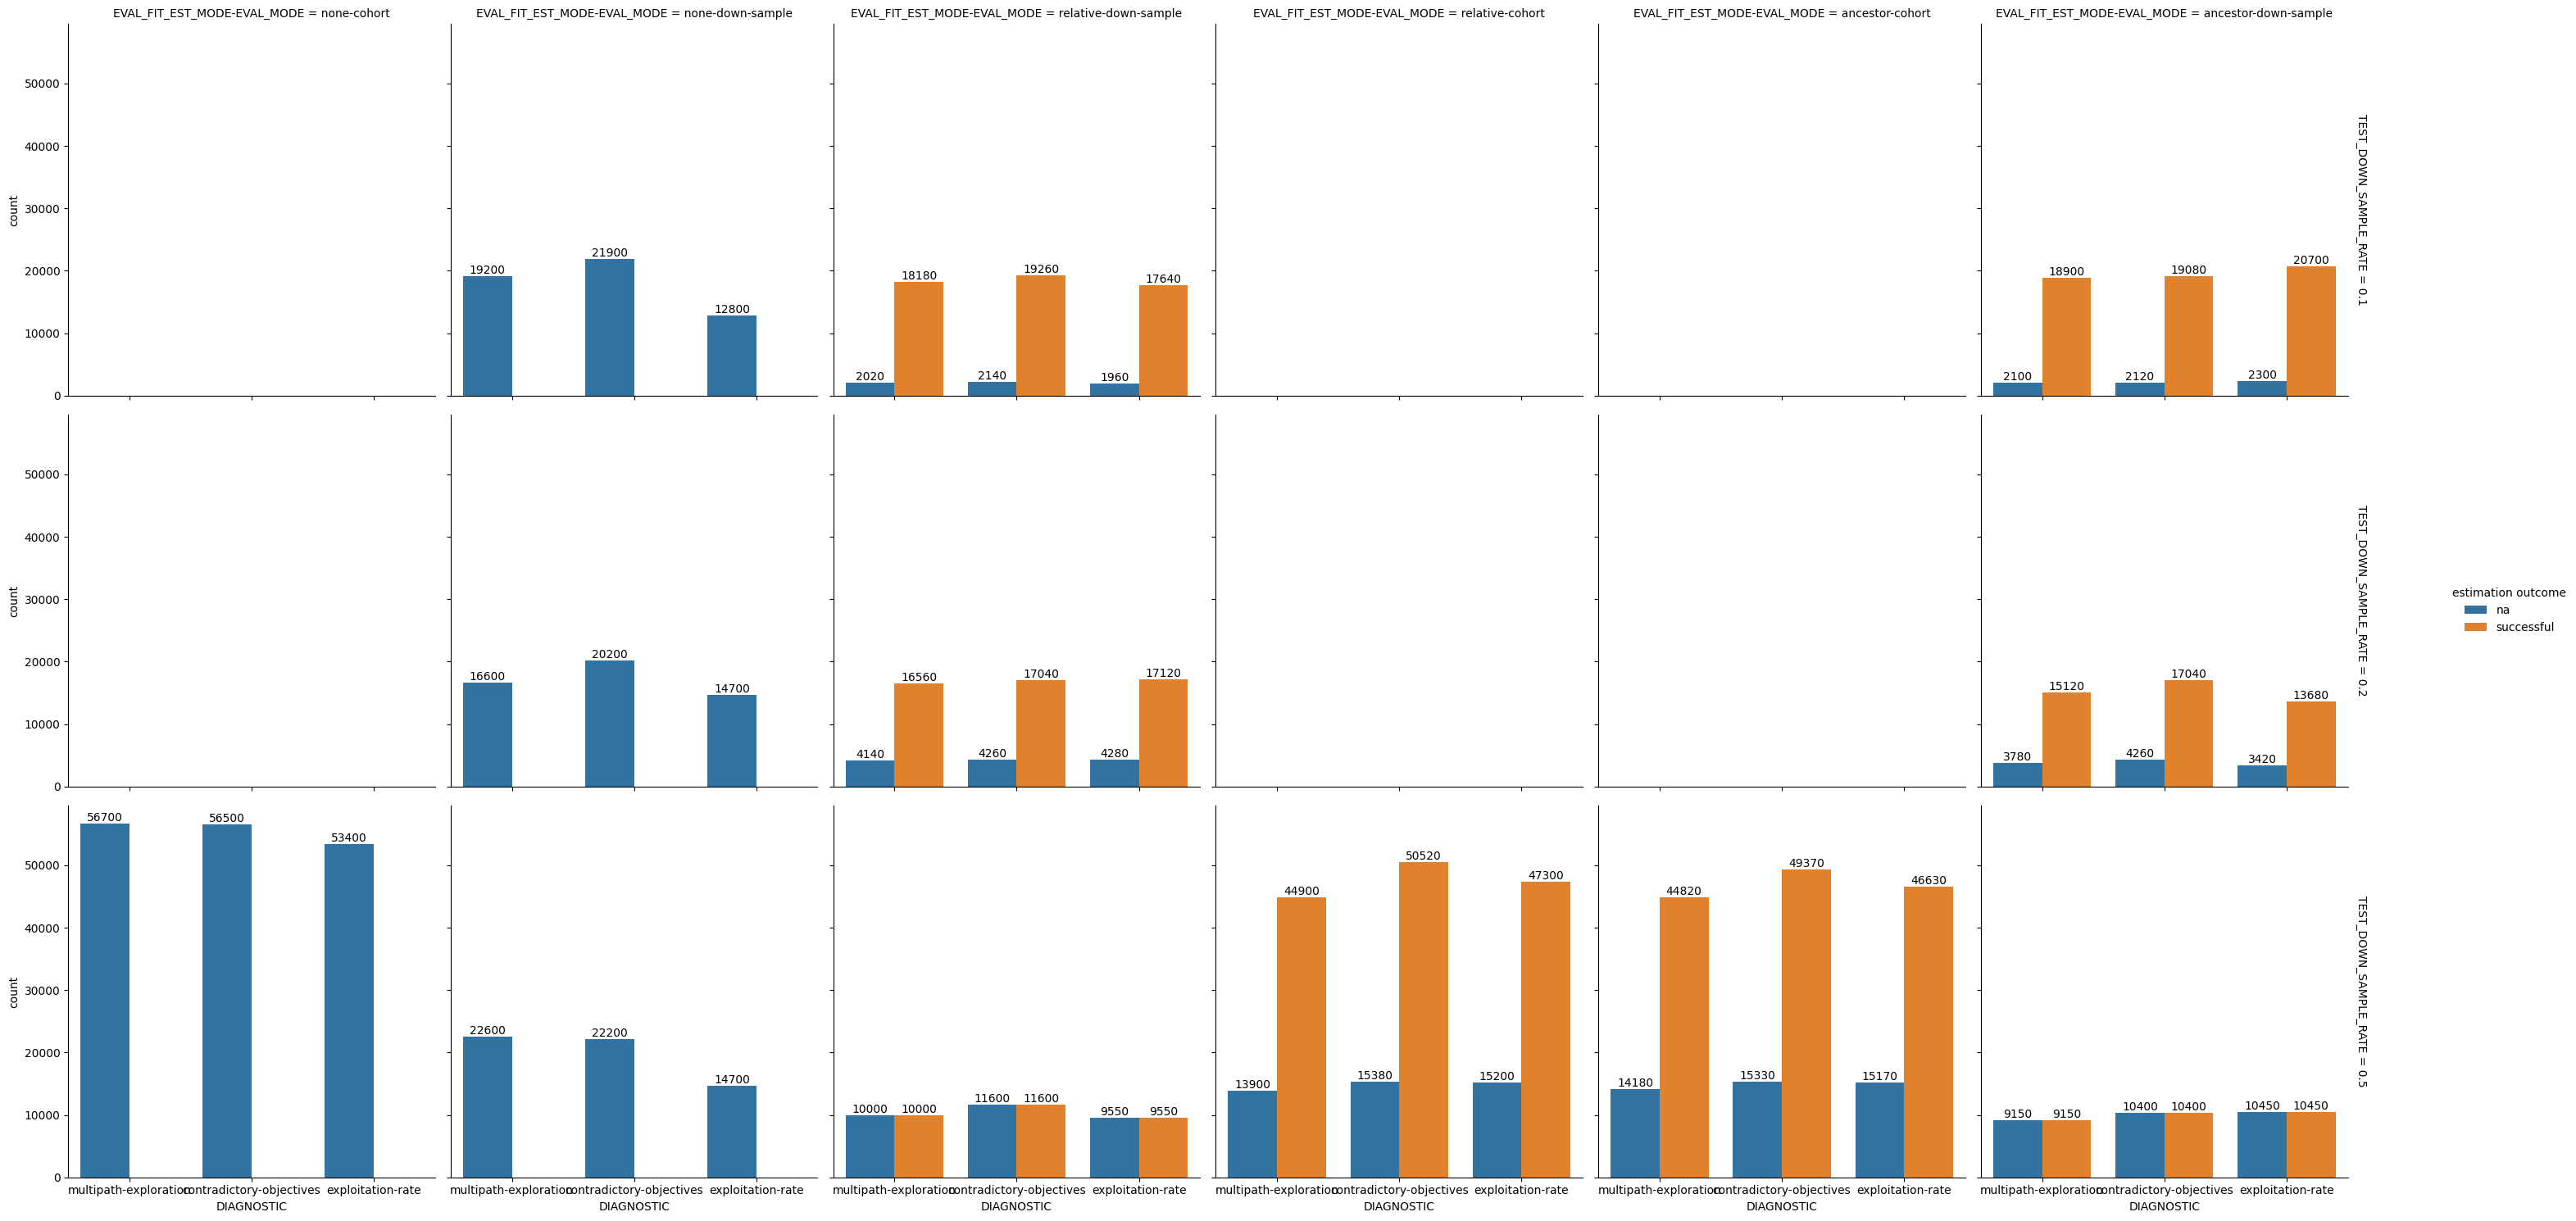

In [31]:
def catplot_bar_label(*args, **kwargs):
    g = sns.catplot(
        *args,
        **kwargs,
        margin_titles=True,
    )
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, label_type='edge')

tp.tee(
    catplot_bar_label,
    data=exploded_df,
    col="EVAL_FIT_EST_MODE-EVAL_MODE",
    row="TEST_DOWN_SAMPLE_RATE",
    x="DIAGNOSTIC",
    hue="estimation outcome",
    kind="count",
)


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-evaluated+ext=.pdf


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-evaluated+ext=.png


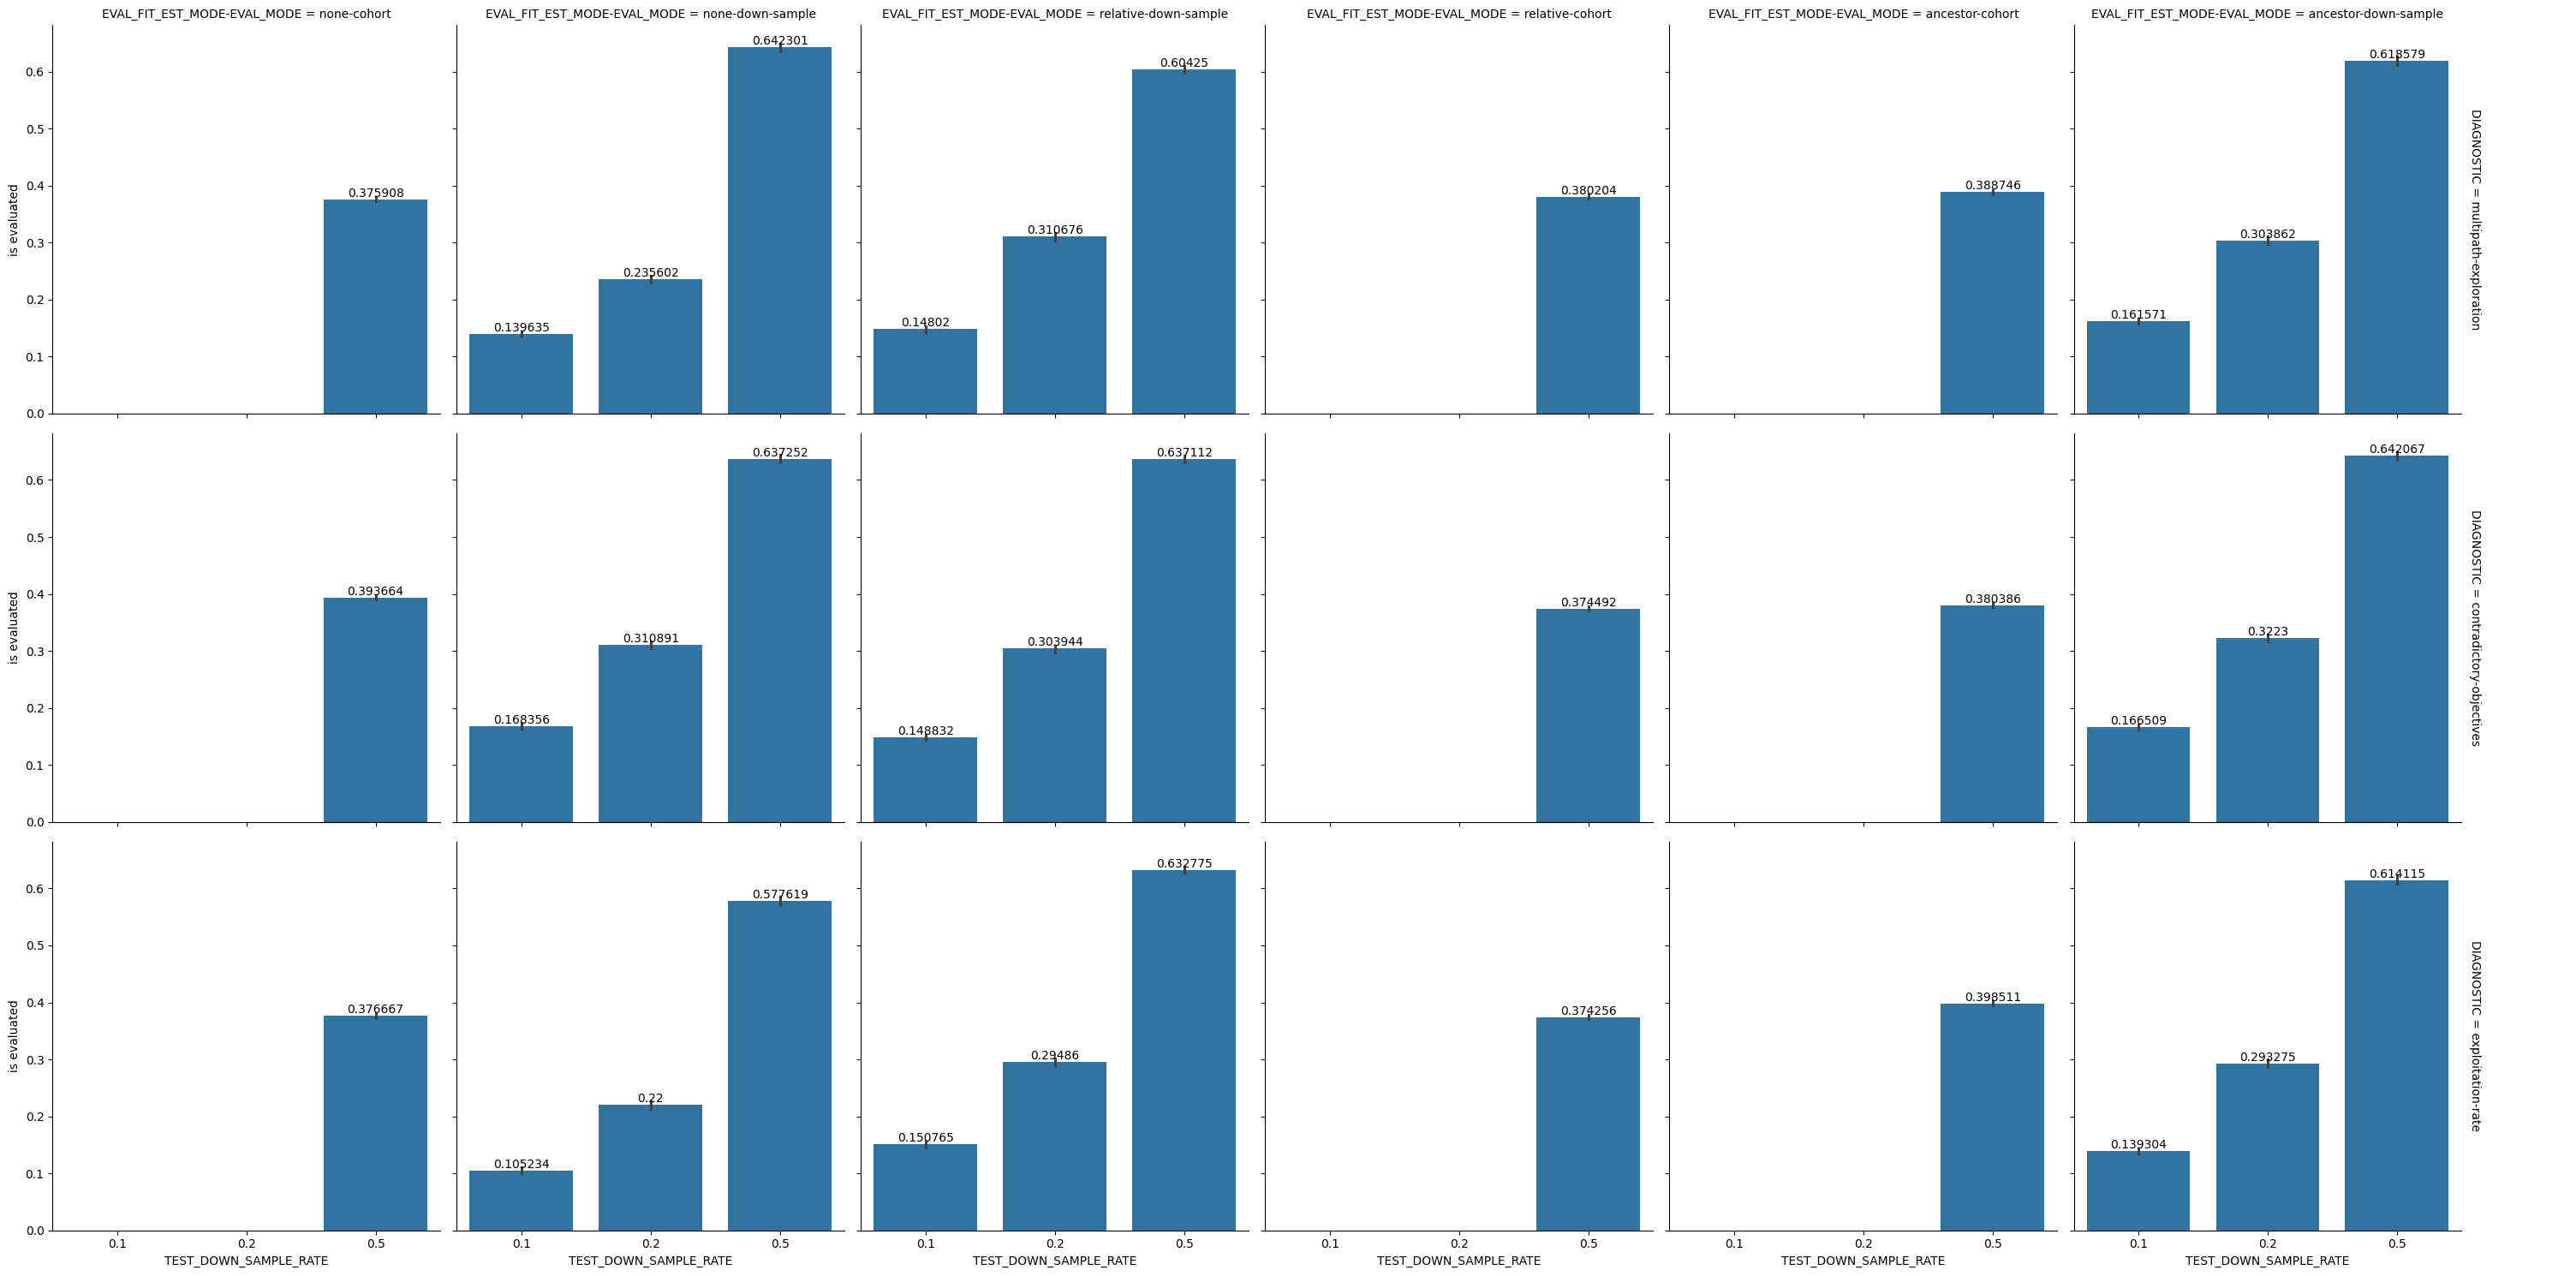

In [32]:
tp.tee(
    catplot_bar_label,
    data=exploded_df,
    col="EVAL_FIT_EST_MODE-EVAL_MODE",
    row="DIAGNOSTIC",
    x="TEST_DOWN_SAMPLE_RATE",
    y="is evaluated",
    kind="bar",
)


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-evaluated-and-is-attempted-estimation+ext=.pdf


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-evaluated-and-is-attempted-estimation+ext=.png


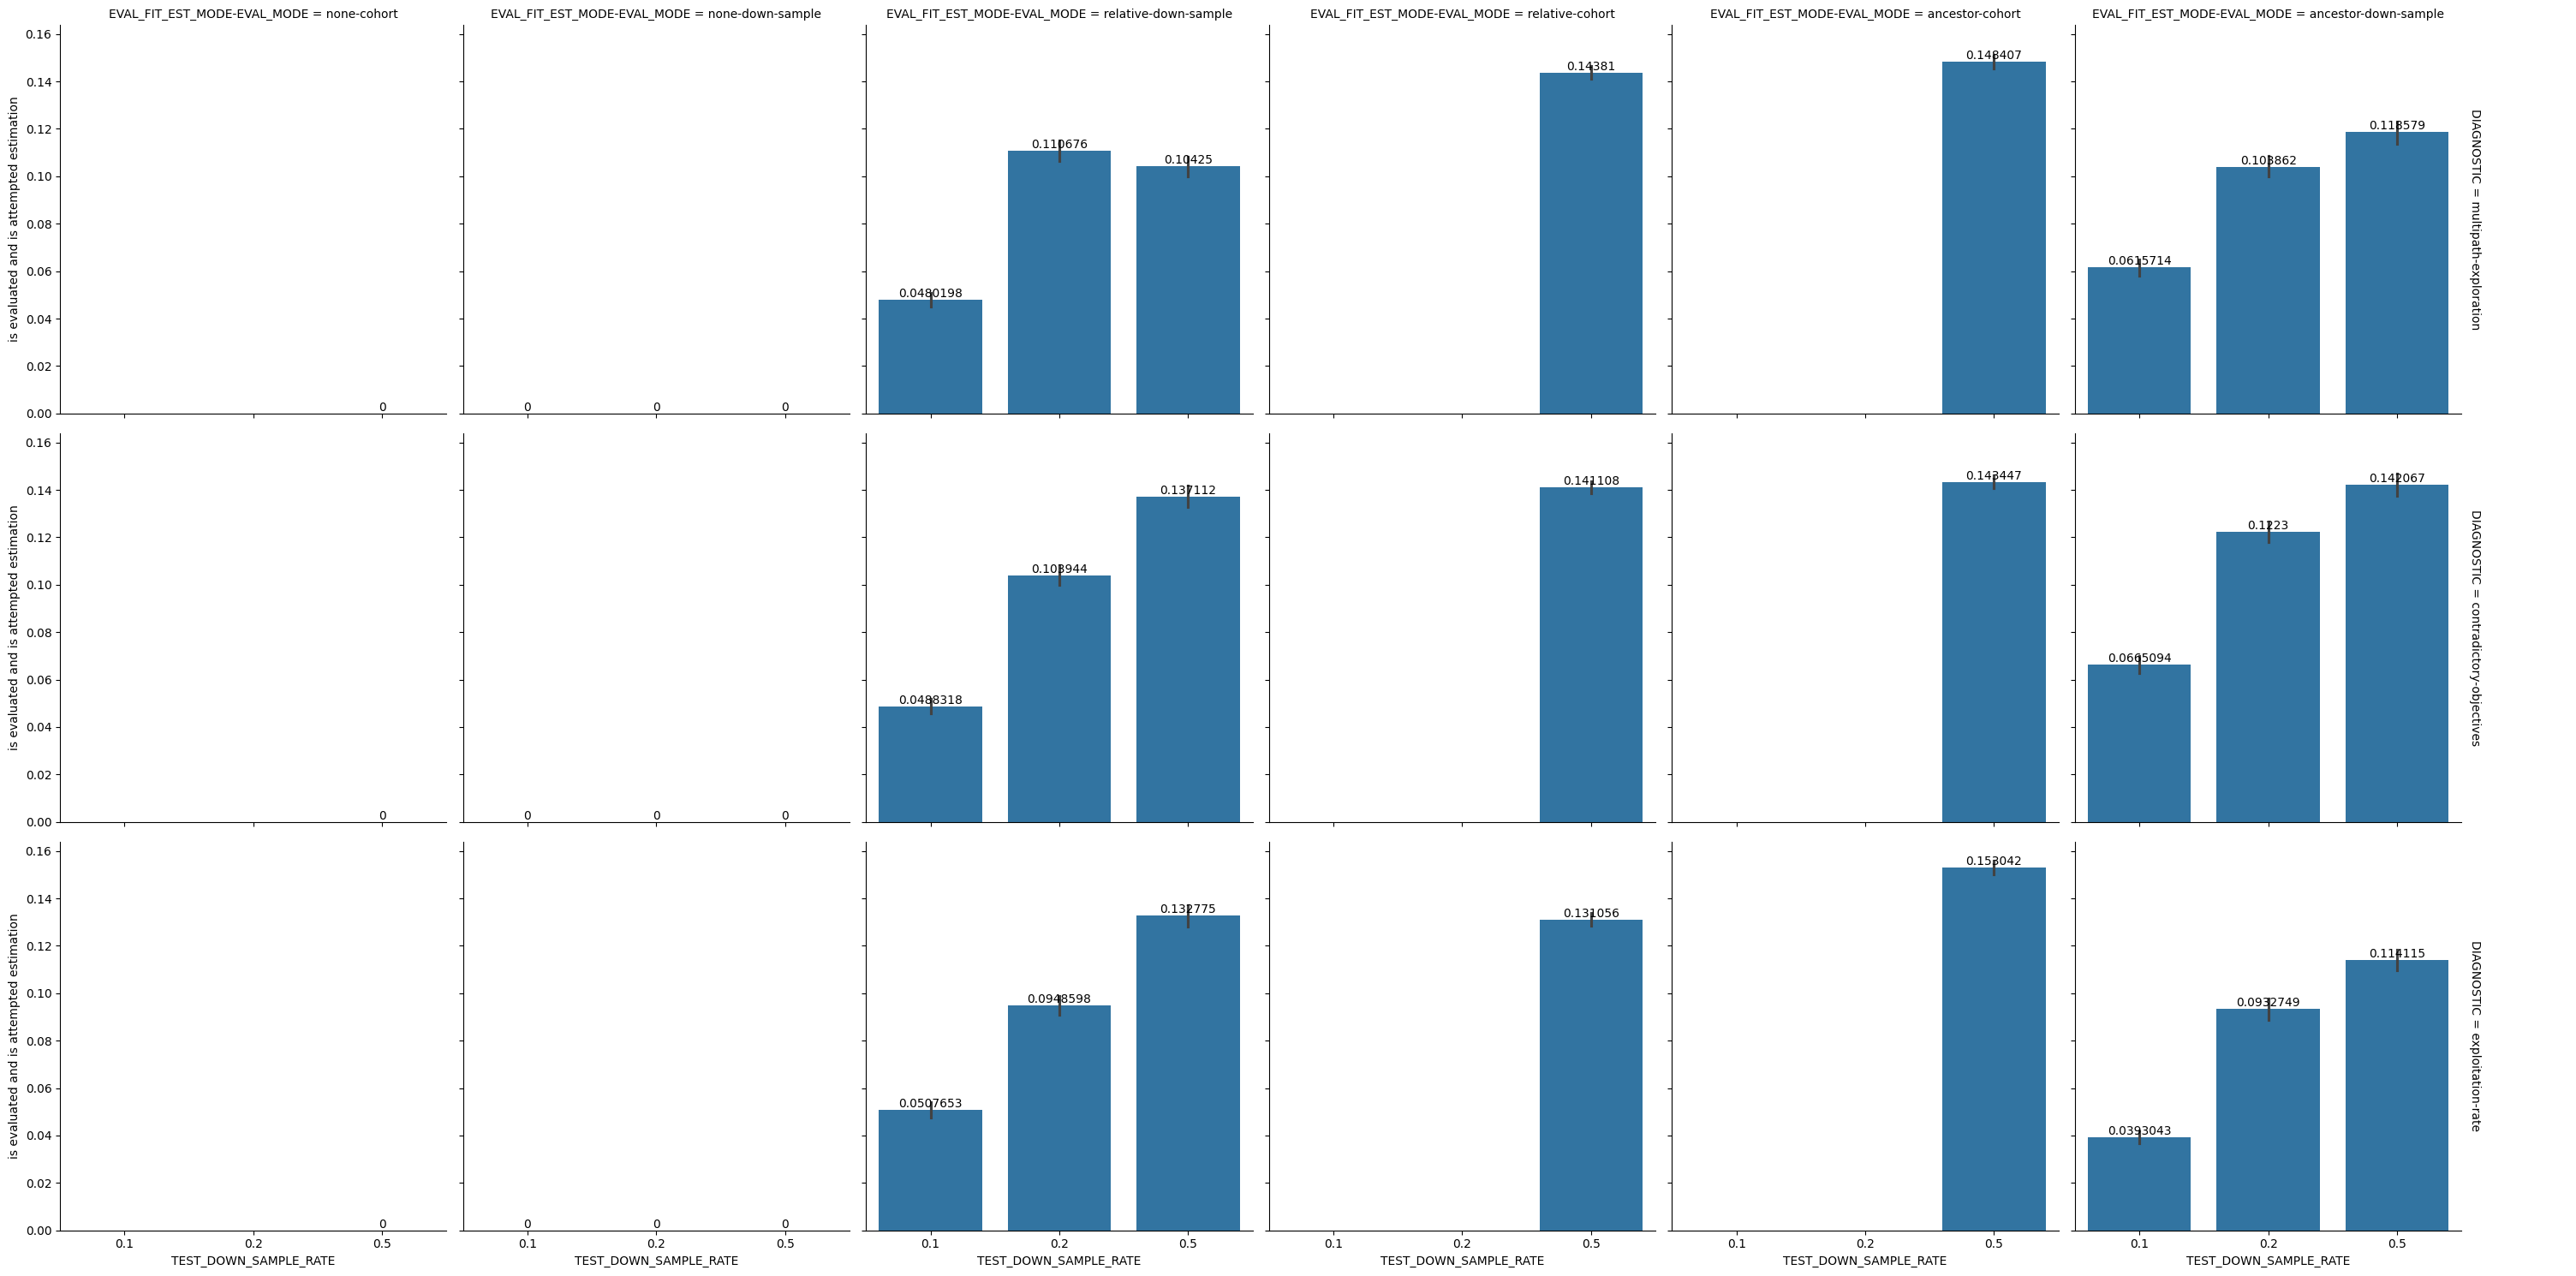

In [33]:
tp.tee(
    catplot_bar_label,
    data=exploded_df,
    col="EVAL_FIT_EST_MODE-EVAL_MODE",
    row="DIAGNOSTIC",
    x="TEST_DOWN_SAMPLE_RATE",
    y="is evaluated and is attempted estimation",
    kind="bar",
)


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-neither-evaluated-nor-attempted-estimation+ext=.pdf


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-neither-evaluated-nor-attempted-estimation+ext=.png


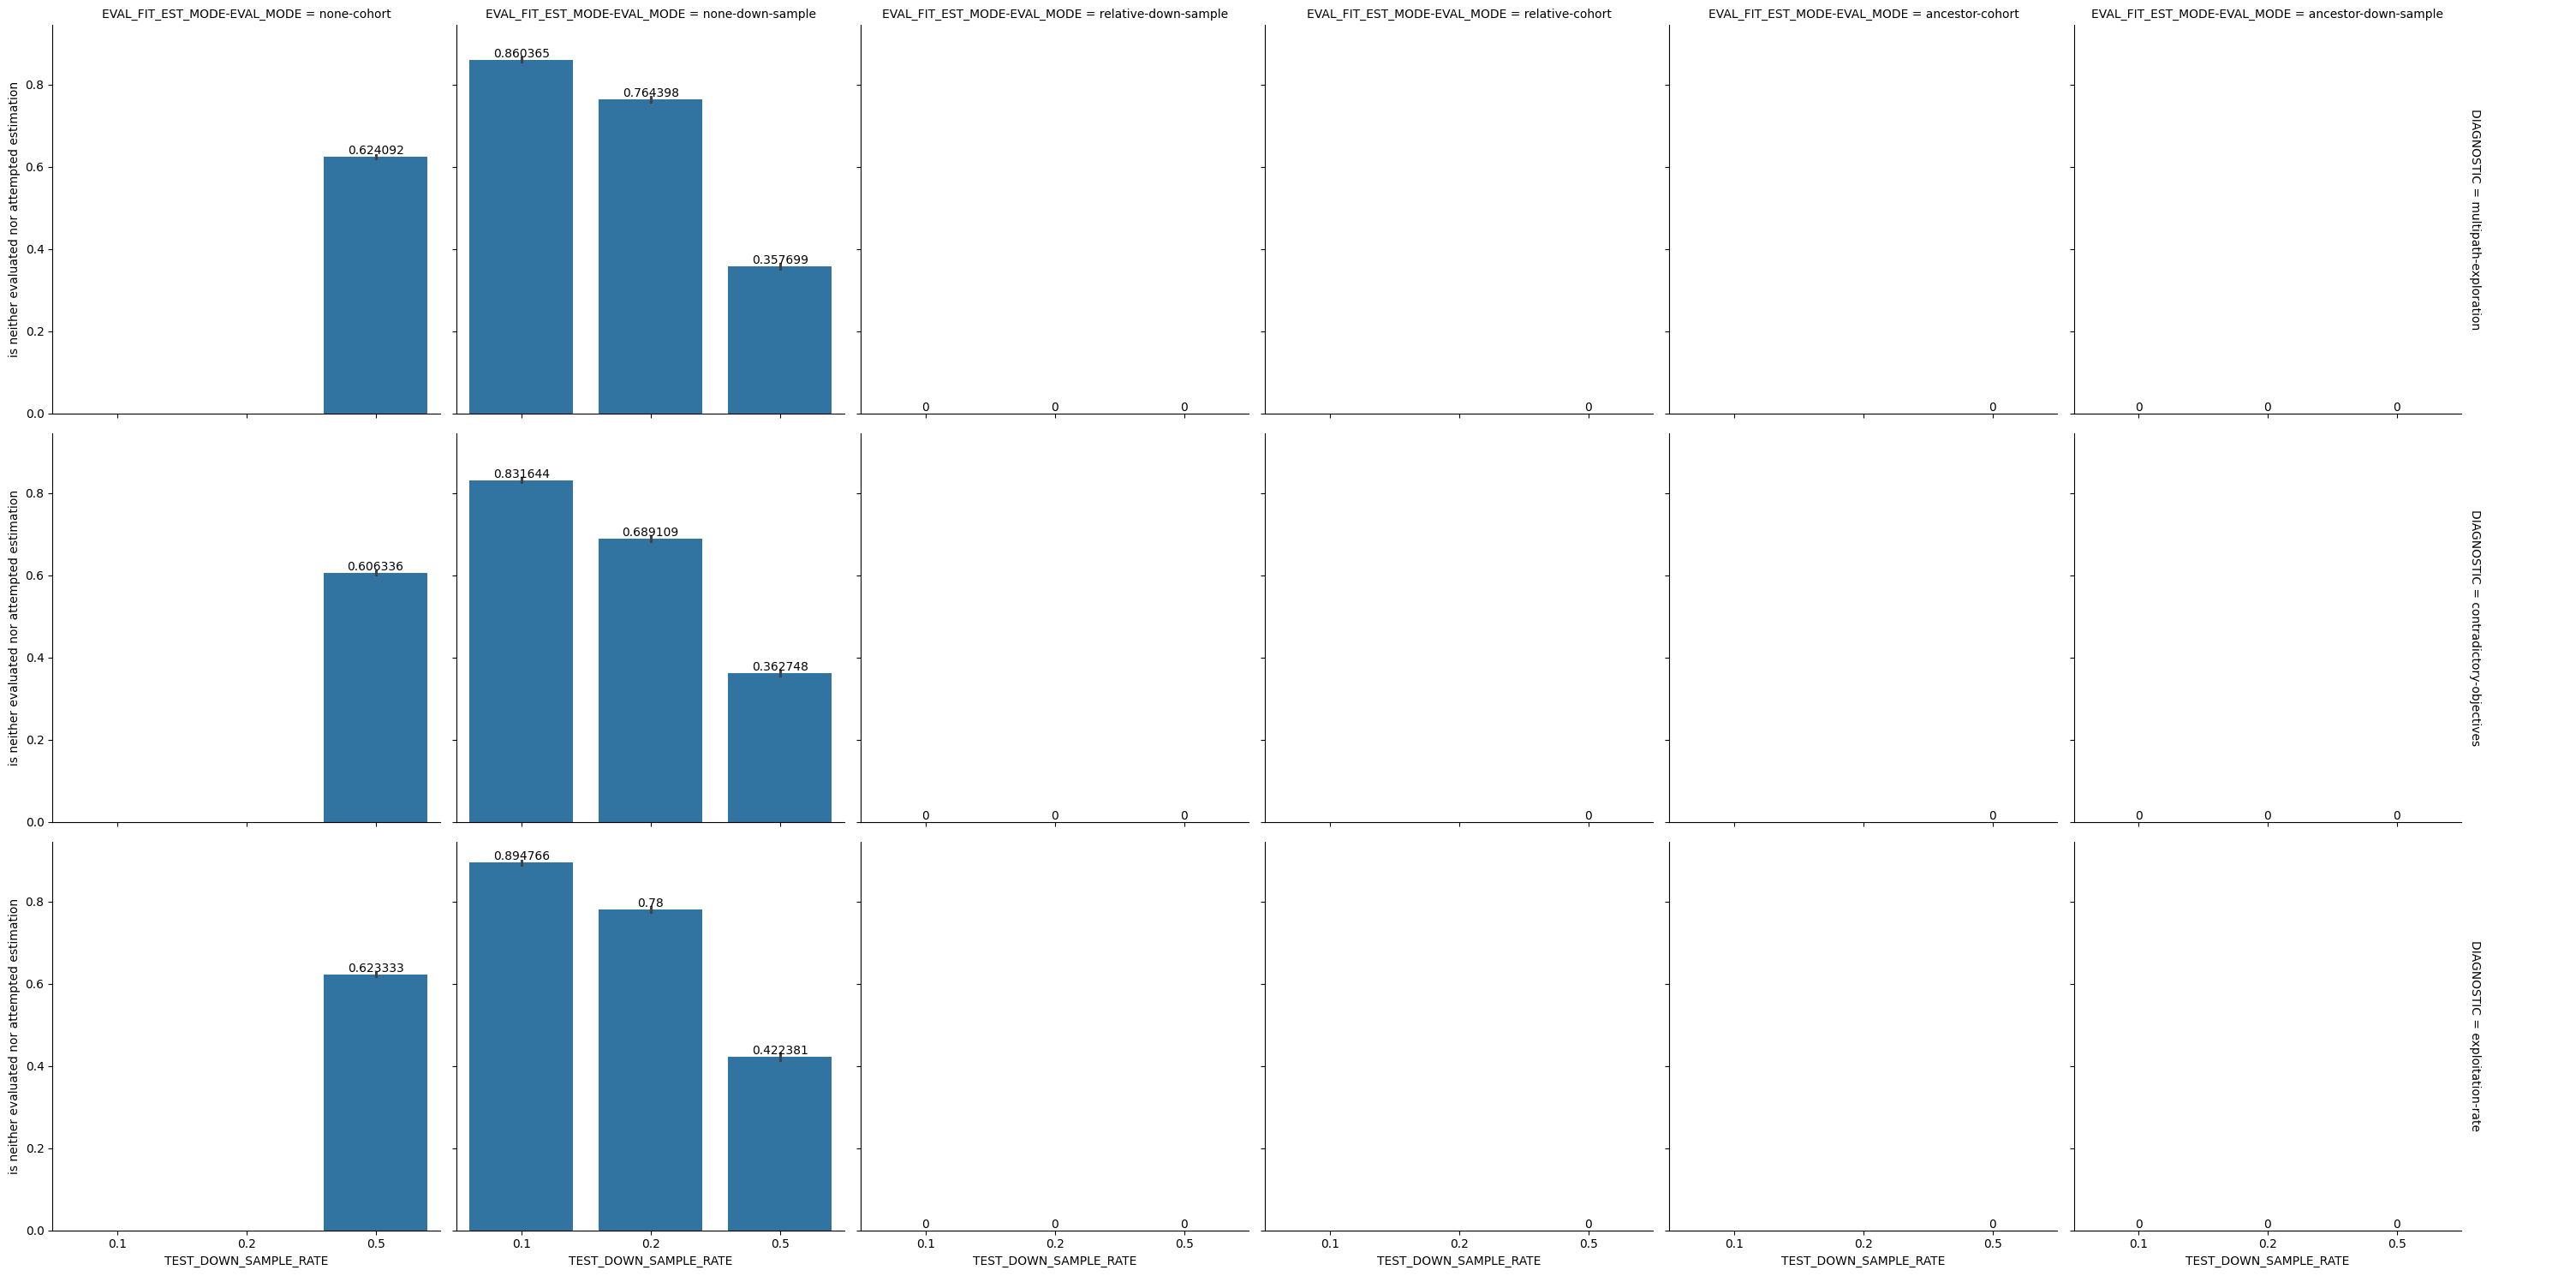

In [34]:
tp.tee(
    catplot_bar_label,
    data=exploded_df,
    col="EVAL_FIT_EST_MODE-EVAL_MODE",
    row="DIAGNOSTIC",
    x="TEST_DOWN_SAMPLE_RATE",
    y="is neither evaluated nor attempted estimation",
    kind="bar",
)


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-attempted-estimation+ext=.pdf


teeplots/col=eval-fit-est-mode-eval-mode+kind=bar+row=diagnostic+viz=catplot-bar-label+x=test-down-sample-rate+y=is-attempted-estimation+ext=.png


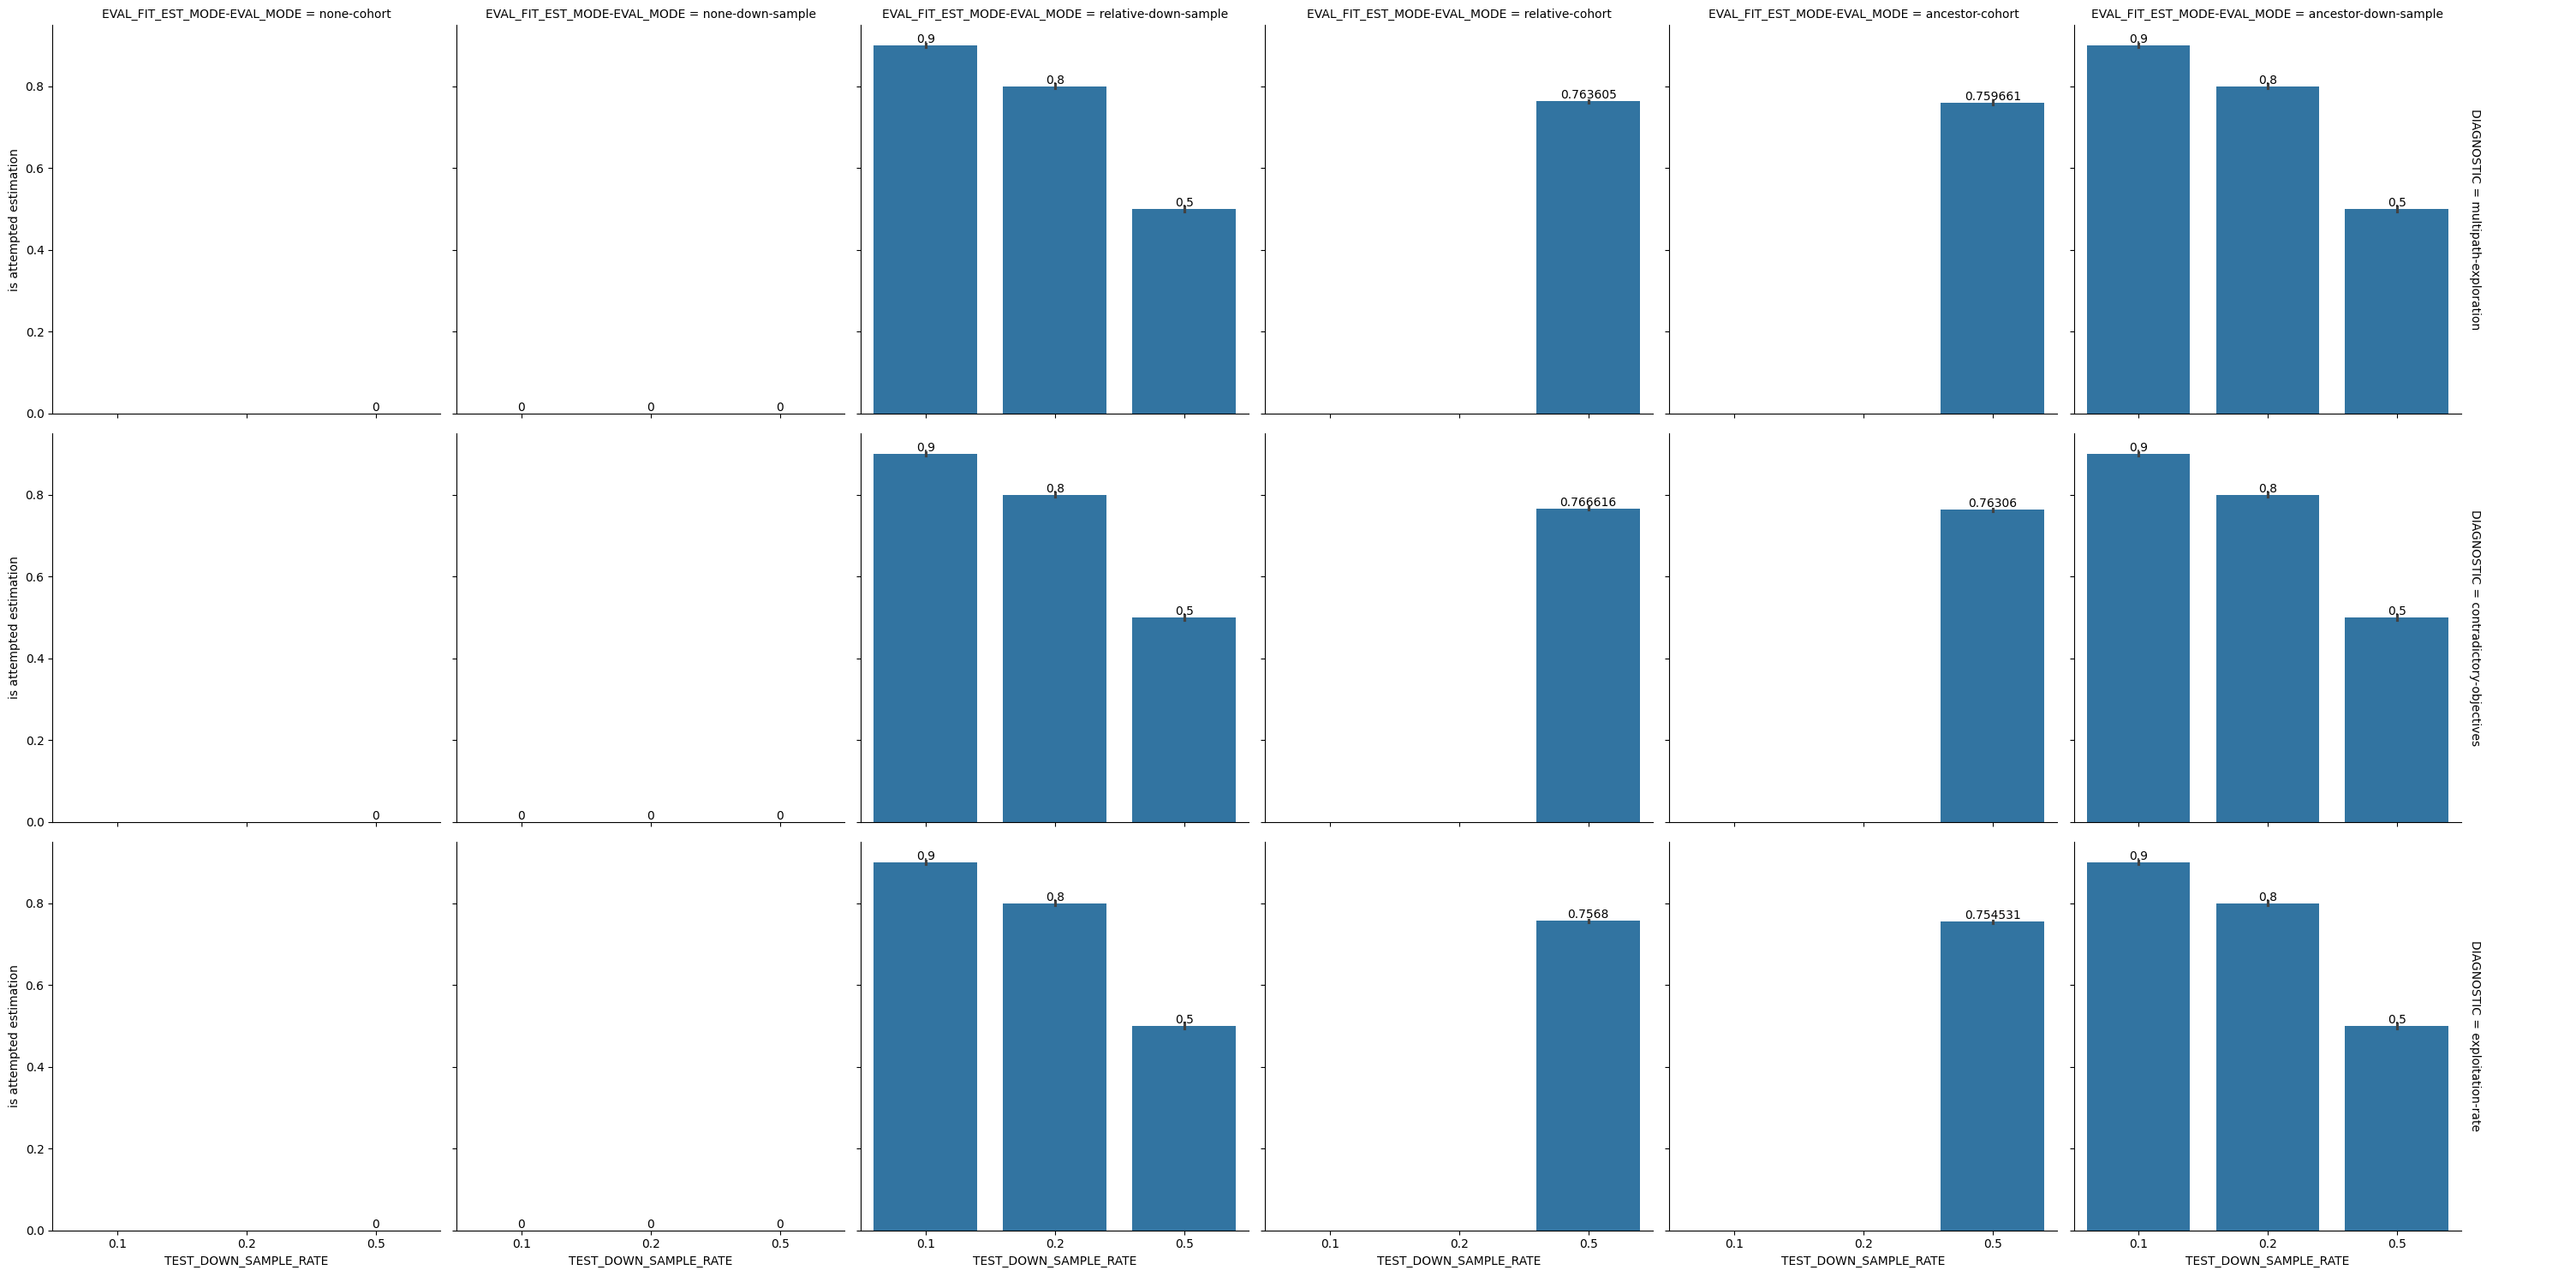

In [35]:
tp.tee(
    catplot_bar_label,
    data=exploded_df,
    col="EVAL_FIT_EST_MODE-EVAL_MODE",
    row="DIAGNOSTIC",
    x="TEST_DOWN_SAMPLE_RATE",
    y="is attempted estimation",
    kind="bar",
)


# Plot: estimated score vs phenotype

by diagnostic and estimate mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=diagnostic+row=eval-fit-est-mode-eval-mode+viz=facet-scatterplot+x=phenotype+y=traits-estimated-scores+ext=.pdf


teeplots/col=diagnostic+row=eval-fit-est-mode-eval-mode+viz=facet-scatterplot+x=phenotype+y=traits-estimated-scores+ext=.png


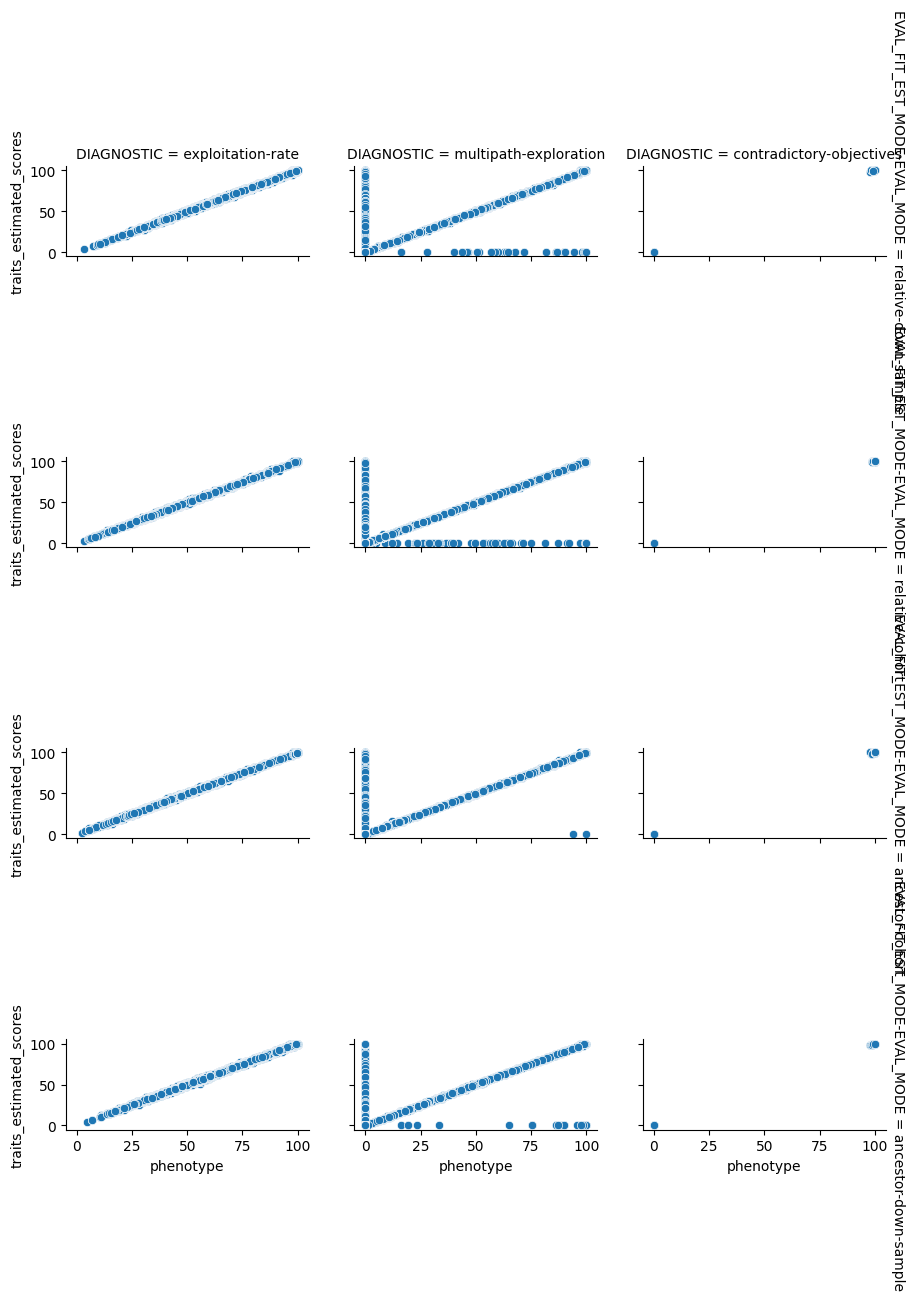

In [36]:
def facet_scatterplot(data, col, row, x, y):
    g = sns.FacetGrid(
        data=data,
        col=col,
        row=row,
        margin_titles=True,
    )
    g.map(
        sns.scatterplot,
        x,
        y,
    )

tp.tee(
    facet_scatterplot,
    data=exploded_df[
        exploded_df["is successful estimation"]
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE-EVAL_MODE",
    x="phenotype",
    y="traits_estimated_scores",
)


# Plot: trait estimation error vs phylogenetic distance

for each diagnostic and estimation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=diagnostic+row=eval-fit-est-mode-eval-mode+viz=facet-regplot+x=traits-estimation-dist+y=abs-normalized-trait-estimation-error+ext=.pdf


teeplots/col=diagnostic+row=eval-fit-est-mode-eval-mode+viz=facet-regplot+x=traits-estimation-dist+y=abs-normalized-trait-estimation-error+ext=.png


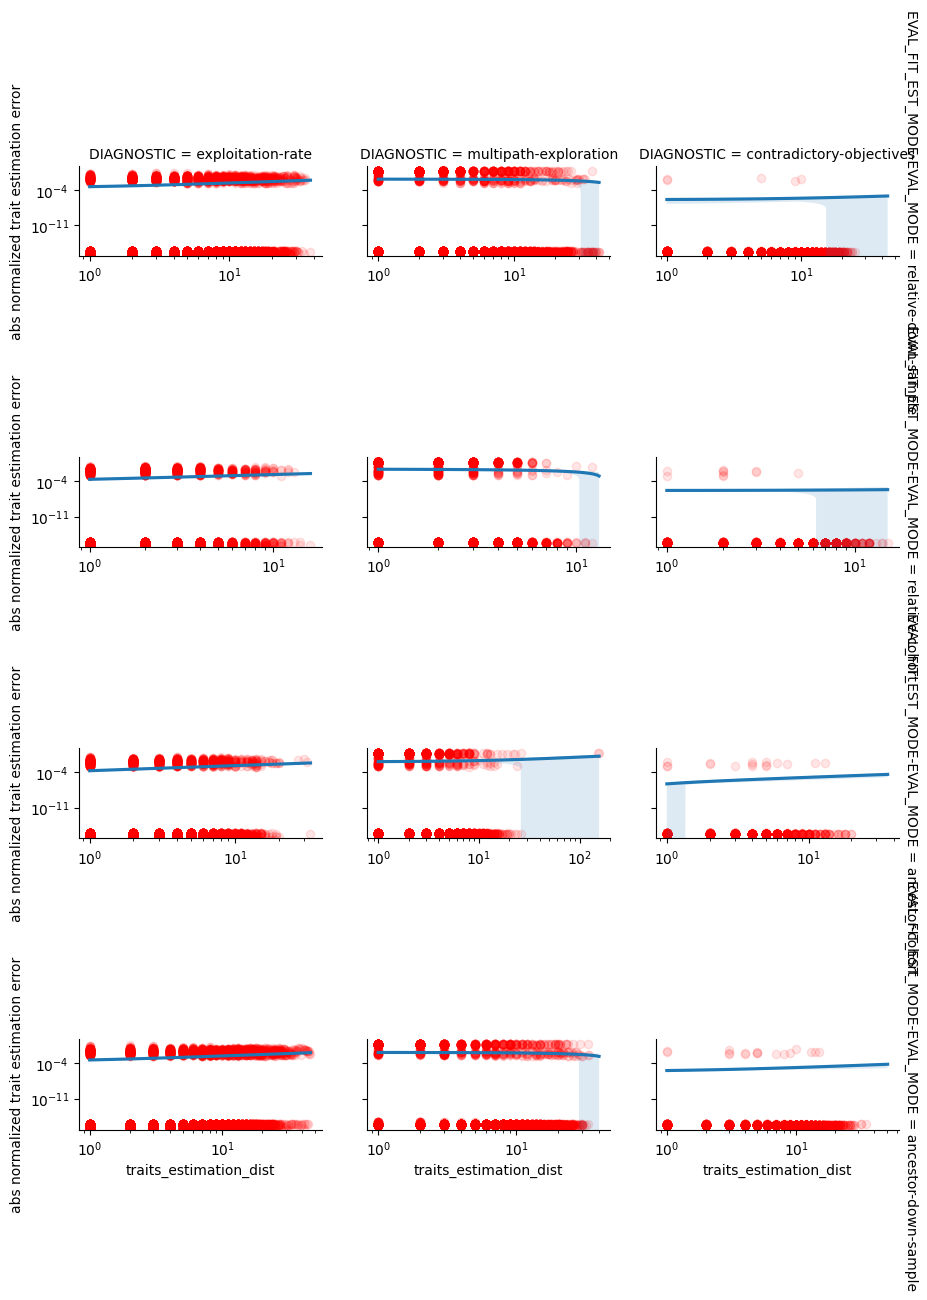

In [37]:
def facet_regplot(data, x, y, col, row):
    g = sns.FacetGrid(
        data=data,
        col=col,
        row=row,
        margin_titles=True,
        sharex=False,
        sharey="row",
    )
    g.map(
        sns.regplot,
        x,
        y,
        n_boot=10,
        scatter_kws={
            "color": "red",
            "alpha": 0.1,
        },
    ).set(
        xscale="log",
        yscale="log",
    )

tp.tee(
    facet_regplot,
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE-EVAL_MODE",
    x="traits_estimation_dist",
    y="abs normalized trait estimation error",
)


In [38]:
def symlog(x, linthresh=1):
    if linthresh <= 0:
        raise ValueError("linthresh should be positive")

    x_abs = np.abs(x)
    sign = np.sign(x)

    log_part = np.log10(x_abs - linthresh + 1) * (x_abs > linthresh)
    lin_part = x * (x_abs <= linthresh)

    return sign * (log_part + lin_part)


/home/runner/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/runner/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (37) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (42) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (43) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (28) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (27) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (27) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (46) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (50) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=diagnostic+hue=log2-traits-estimation-dist+row=eval-fit-est-mode-eval-mode+viz=facet-histplot+x=log2-traits-estimation-dist+y=symlog-normalized-trait-estimation-error+ext=.pdf


teeplots/col=diagnostic+hue=log2-traits-estimation-dist+row=eval-fit-est-mode-eval-mode+viz=facet-histplot+x=log2-traits-estimation-dist+y=symlog-normalized-trait-estimation-error+ext=.png


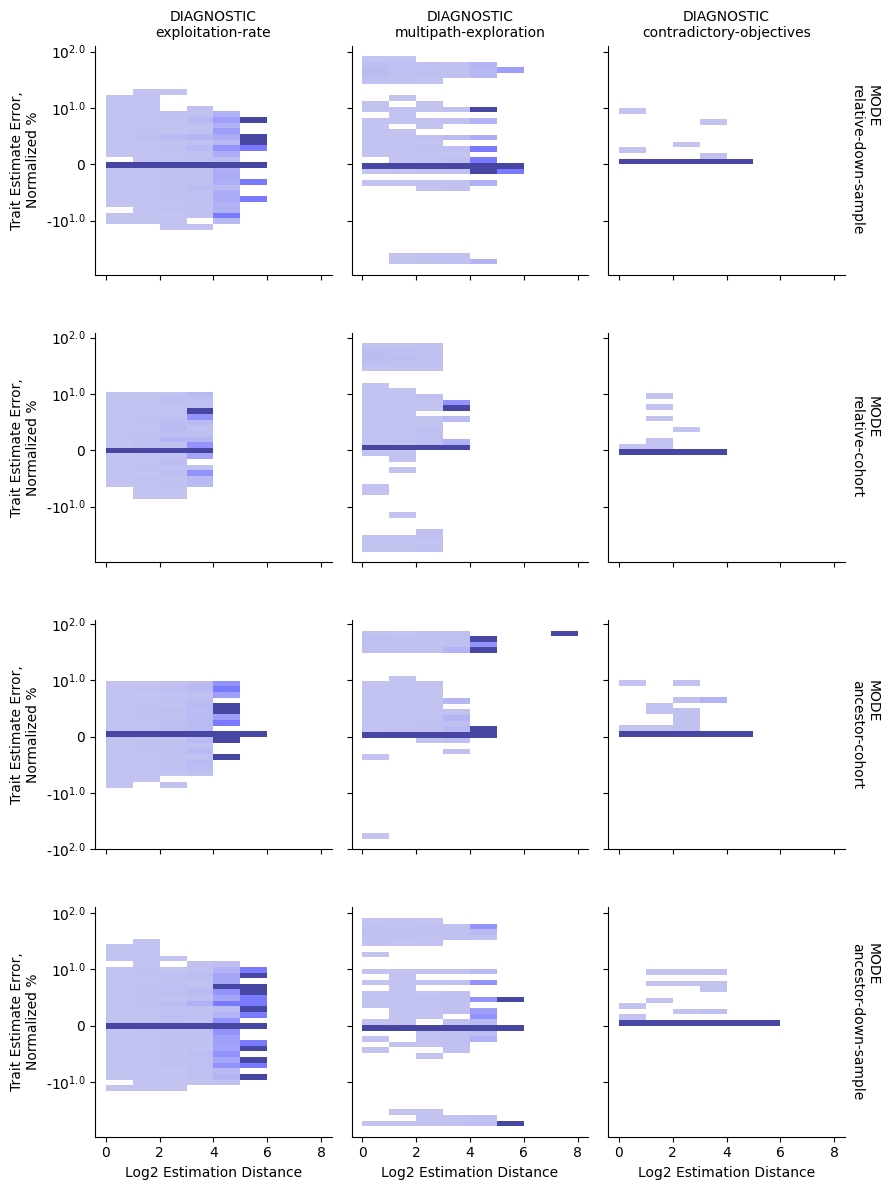

In [39]:
def symlog_formatter(x, pos):
    sign = '-' if x < 0 else ''
    x_abs = abs(x)
    return f'{sign}$10^{{{x_abs}}}$' if x else "0"

def facet_histplot(data, x, y, hue, col, row):
    g = sns.FacetGrid(
        data=data,
        col=col,
        row=row,
        margin_titles=True,
        sharex=True,
        sharey="row",
        aspect=1,
    )
    g.map(
        sns.histplot,
        x,
        y,
        hue,
        binwidth=(1, 0.1),
        palette=sns.color_palette(["blue"]),
        common_norm=False,
    ).set_axis_labels(
        x_var="Log2 Estimation Distance",
        y_var="Trait Estimate Error,\nNormalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="MODE\n{row_name}",
    )

    # Create a FuncFormatter instance with the custom function
    formatter = mpl_FuncFormatter(symlog_formatter)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(formatter)

    plt.tight_layout()



# tp.tee(
#     sns.displot,
exploded_df["log2 traits_estimation_dist"] = np.log2(exploded_df["traits_estimation_dist"])
exploded_df["symlog normalized trait estimation error %"] = symlog(exploded_df["normalized trait estimation error %"])

tp.tee(
    facet_histplot,
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE-EVAL_MODE",
    x="log2 traits_estimation_dist",
    y="symlog normalized trait estimation error %",
    hue="log2 traits_estimation_dist",
)


/home/runner/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/runner/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (37) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (42) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (43) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (28) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (27) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (27) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (46) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (50) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=diagnostic+hue=log2-traits-estimation-dist+row=eval-fit-est-mode-eval-mode+viz=facet-histplot+x=log2-traits-estimation-dist+y=symlog-abs-normalized-trait-estimation-error+ext=.pdf


teeplots/col=diagnostic+hue=log2-traits-estimation-dist+row=eval-fit-est-mode-eval-mode+viz=facet-histplot+x=log2-traits-estimation-dist+y=symlog-abs-normalized-trait-estimation-error+ext=.png


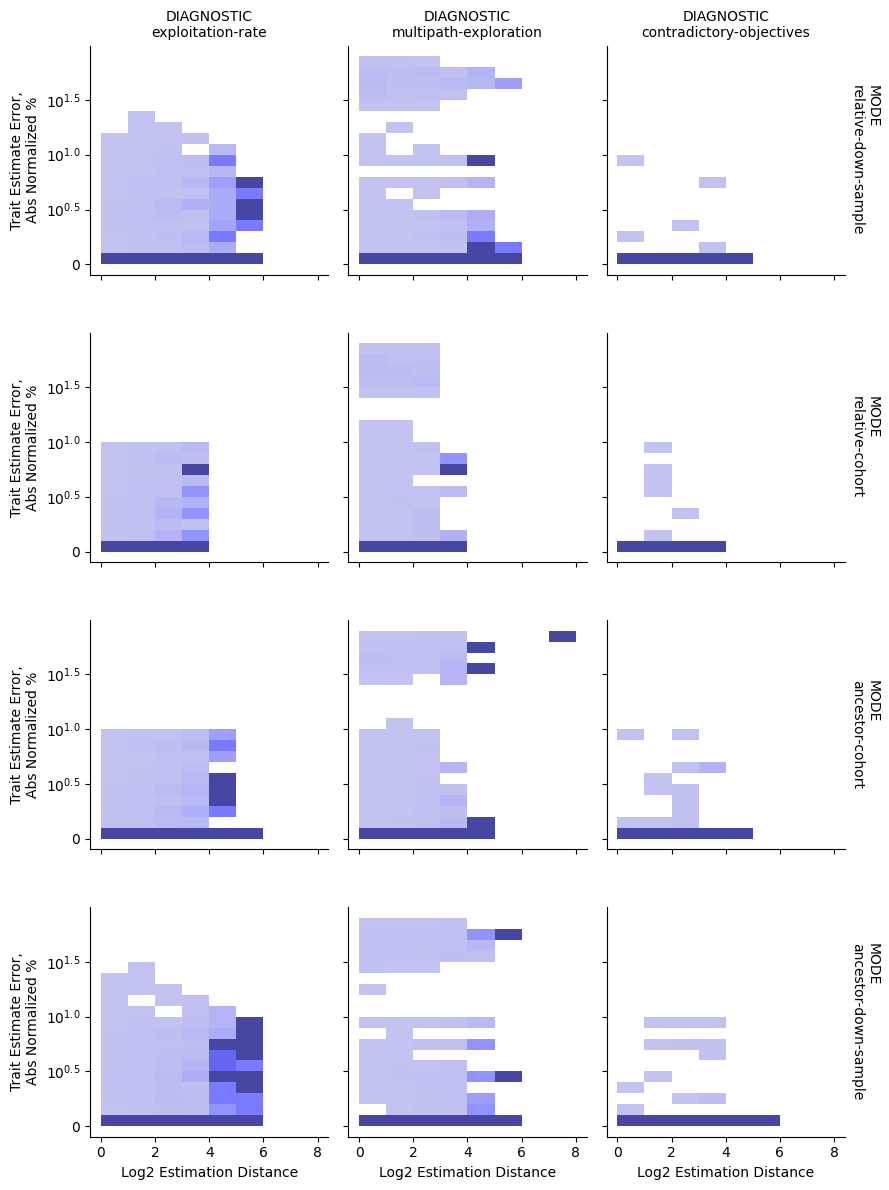

In [40]:
def facet_histplot(data, x, y, hue, col, row):
    g = sns.FacetGrid(
        data=data,
        col=col,
        row=row,
        margin_titles=True,
        sharex=True,
        sharey="row",
        aspect=1,
    )
    g.map(
        sns.histplot,
        x,
        y,
        hue,
        binwidth=(1, 0.1),
        palette=sns.color_palette(["blue"]),
        common_norm=False,
    ).set_axis_labels(
        x_var="Log2 Estimation Distance",
        y_var="Trait Estimate Error,\nAbs Normalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="MODE\n{row_name}",
    )

    # Create a FuncFormatter instance with the custom function
    formatter = mpl_FuncFormatter(symlog_formatter)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(formatter)

    plt.tight_layout()



exploded_df["log2 traits_estimation_dist"] = np.log2(exploded_df["traits_estimation_dist"])
exploded_df["symlog abs normalized trait estimation error %"] = symlog(exploded_df["abs normalized trait estimation error %"])
tp.tee(
    facet_histplot,
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE-EVAL_MODE",
    x="log2 traits_estimation_dist",
    y="symlog abs normalized trait estimation error %",
    hue="log2 traits_estimation_dist",
)


# Plot: mean estimation error by diagnostic/estimation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


teeplots/col=test-down-sample-rate+row=diagnostic+viz=facet-barplot+x=eval-fit-est-mode-eval-mode+y=trait-estimation-abs-error+ext=.pdf


teeplots/col=test-down-sample-rate+row=diagnostic+viz=facet-barplot+x=eval-fit-est-mode-eval-mode+y=trait-estimation-abs-error+ext=.png


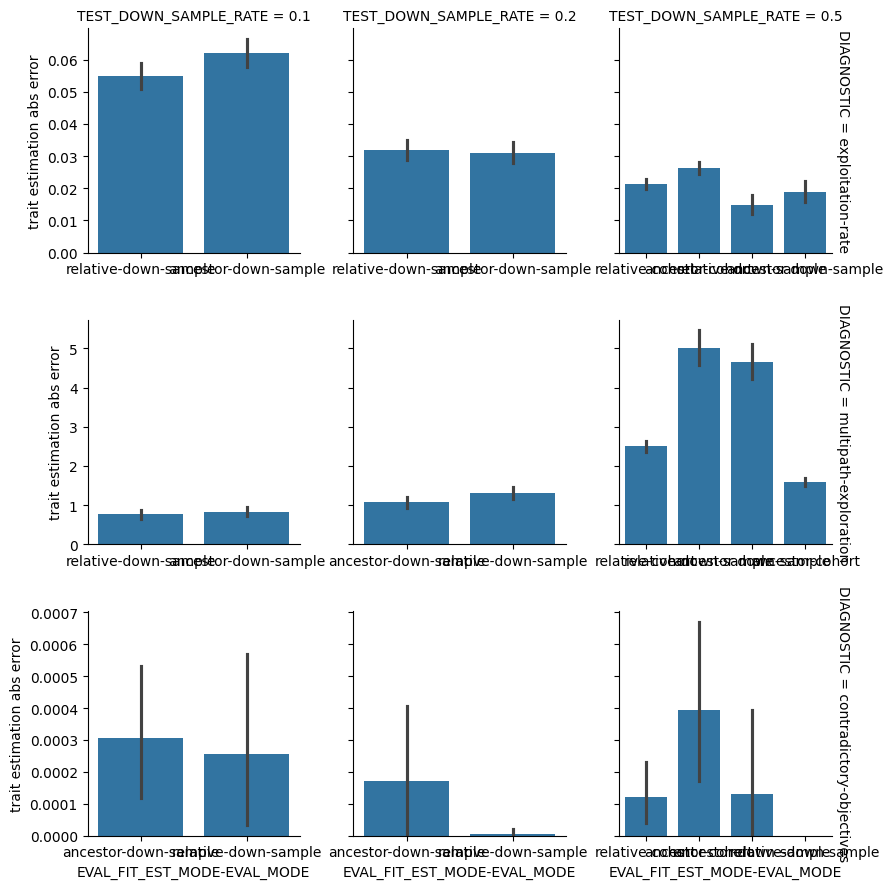

In [41]:
def facet_barplot(data, x, y, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey="row",
        sharex=False,
    )
    g.map(
        sns.barplot,
        x,
        y,
    )

tp.tee(
    facet_barplot,
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_FIT_EST_MODE-EVAL_MODE",
    y="trait estimation abs error",
    row="DIAGNOSTIC",
    col="TEST_DOWN_SAMPLE_RATE",
)


## normalized


In [42]:
def facet_violinplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.violinplot,
        x,
        y,
        hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimate Error, Normalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

facet_violinplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="abs normalized trait estimation error %",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [43]:
def facet_boxplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.boxplot,
        x,
        y,
        hue,
        palette="tab10",
        showfliers=False,
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimate Error, Normalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

facet_boxplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="abs normalized trait estimation error %",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [44]:
def facet_barplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.barplot,
        x,
        y,
        hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimate Error, Normalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(
                container,
                label_type='edge',
                padding=15,
                fmt="%.2f%%",
            )

facet_barplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="abs normalized trait estimation error %",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [45]:
def facet_barplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.barplot,
        x,
        y,
        hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimate Error, Normalized %",
    ).set_titles(
        col_template="{col_var} {col_name}",
        row_template="{row_var}\n{row_name}",
    )
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(
                container,
                label_type='edge',
                padding=15,
                fmt="%.2f%%",
            )

facet_barplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="abs normalized trait estimation error %",
    hue="EVAL_FIT_EST_MODE",
    row="DIAGNOSTIC",
    col="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


# normalized, not absolute value


In [46]:
def facet_barplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.barplot,
        x,
        y,
        hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimate Error,\nNormalized %",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(
                container,
                label_type='edge',
                padding=15,
                fmt="%.2f%%",
            )

facet_barplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="normalized trait estimation error %",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


# Plot: phylogenetic estimation distance by diagnostic/estimation mode


In [47]:
def facet_barplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.barplot,
        x,
        y,
        hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimation Distance",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

facet_barplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="traits_estimation_dist",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [48]:
def facet_boxplot(data, x, y, hue, row, col):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map(
        sns.boxplot,
        x,
        y,
        hue,
        palette="tab10",
        showfliers=False,
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimation Distance",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

facet_boxplot(
    data=exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    x="EVAL_MODE",
    y="traits_estimation_dist",
    hue="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


# Plot: error distributions

by diagnostic/evaluation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


teeplots/col=diagnostic+row=test-down-sample-rate+viz=facet-violinplot+x=trait-estimation-abs-error+y=eval-fit-est-mode-eval-mode+ext=.pdf


teeplots/col=diagnostic+row=test-down-sample-rate+viz=facet-violinplot+x=trait-estimation-abs-error+y=eval-fit-est-mode-eval-mode+ext=.png


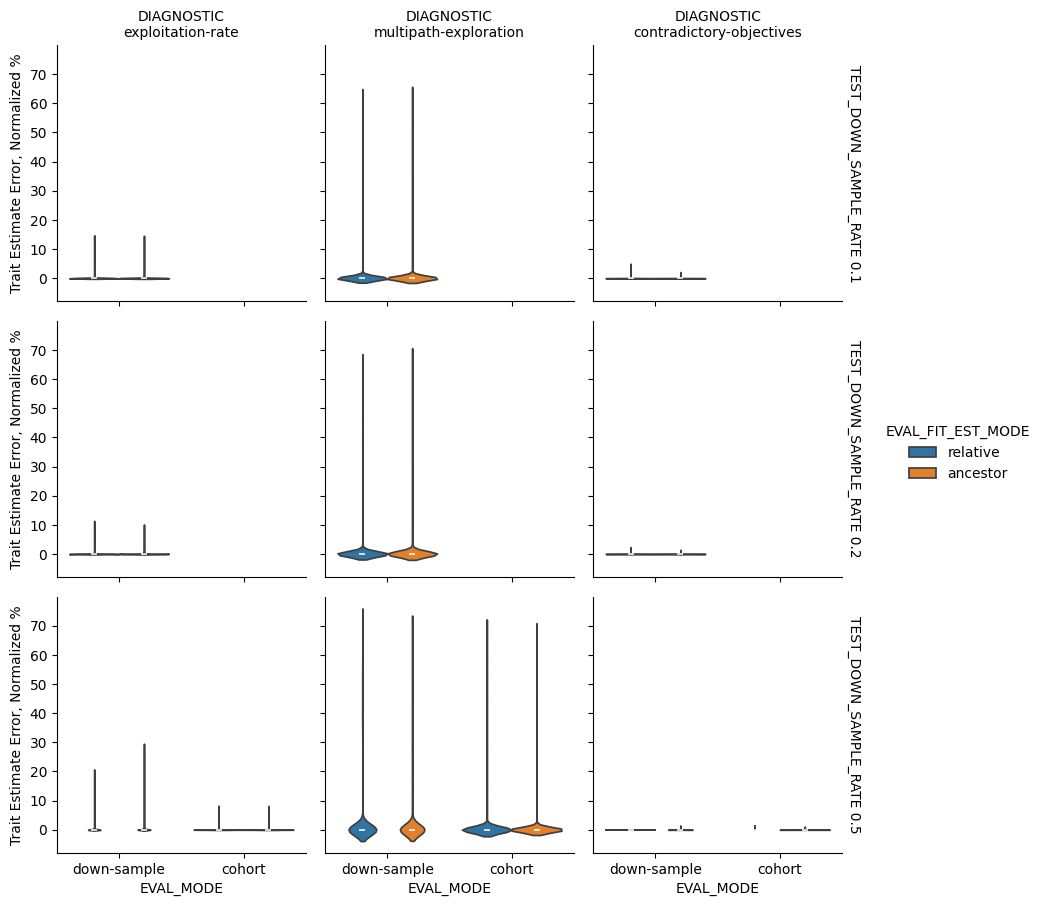

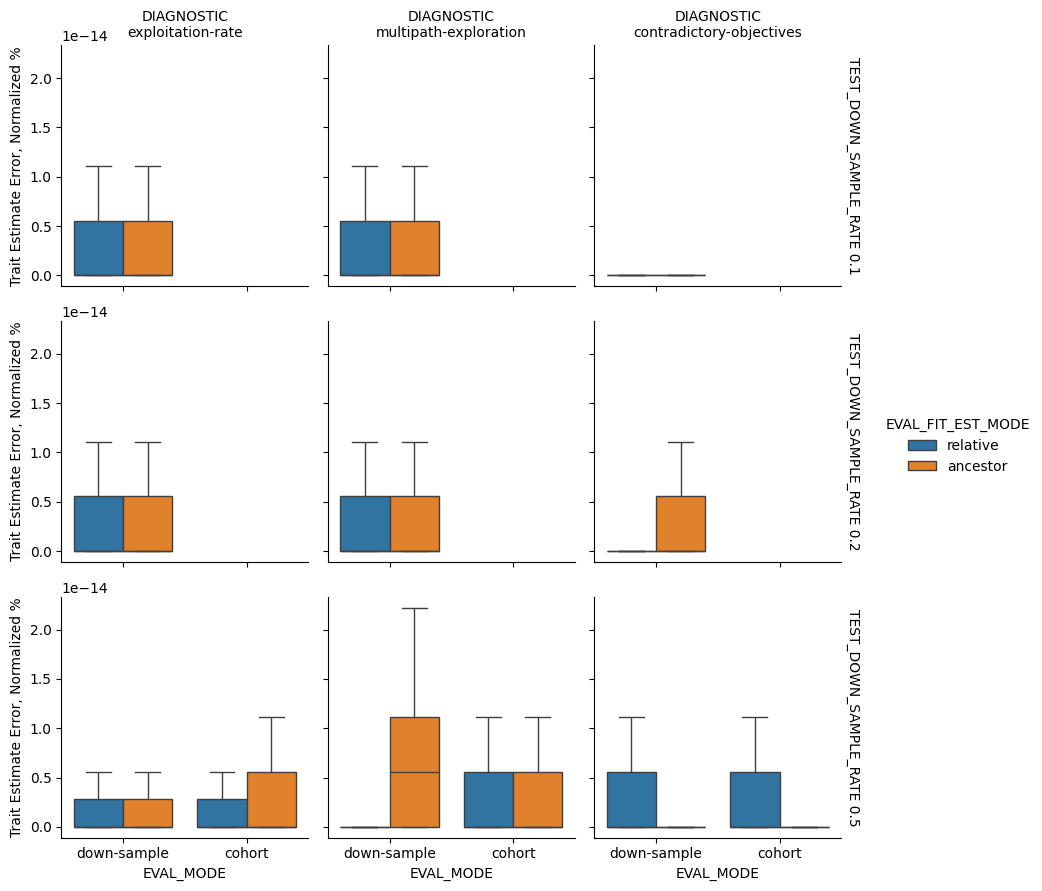

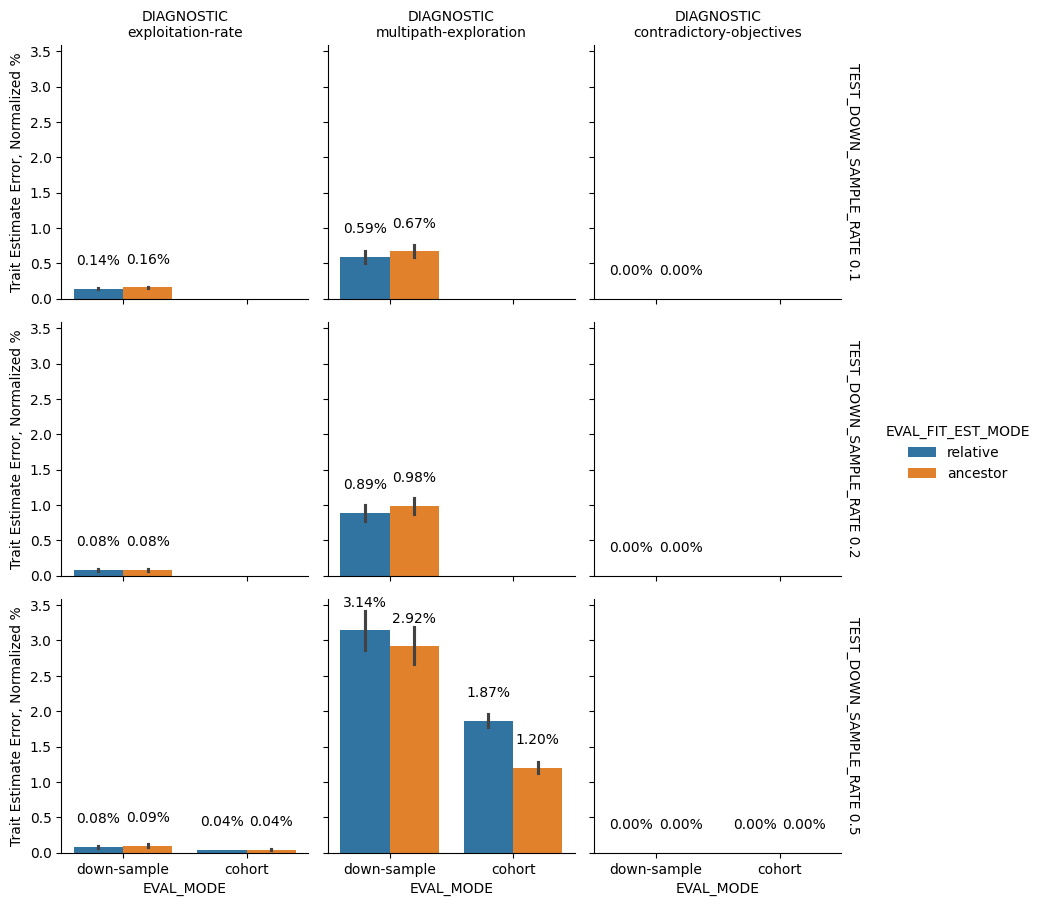

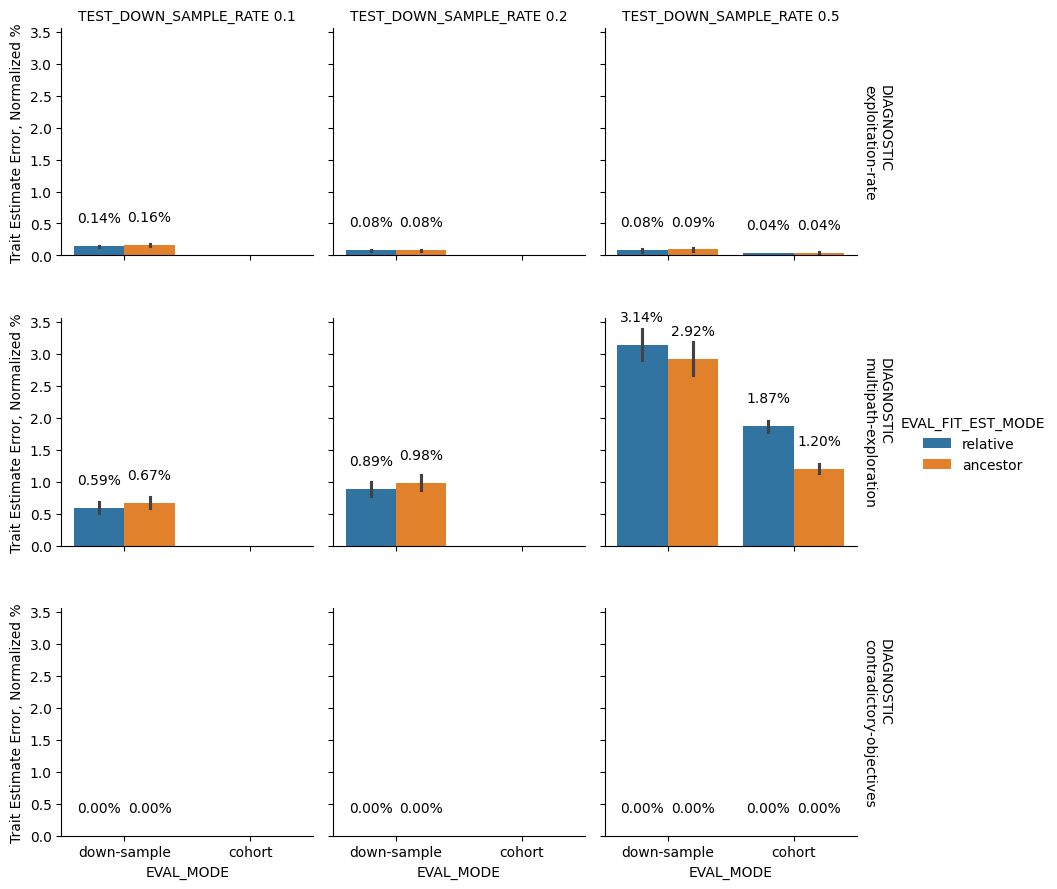

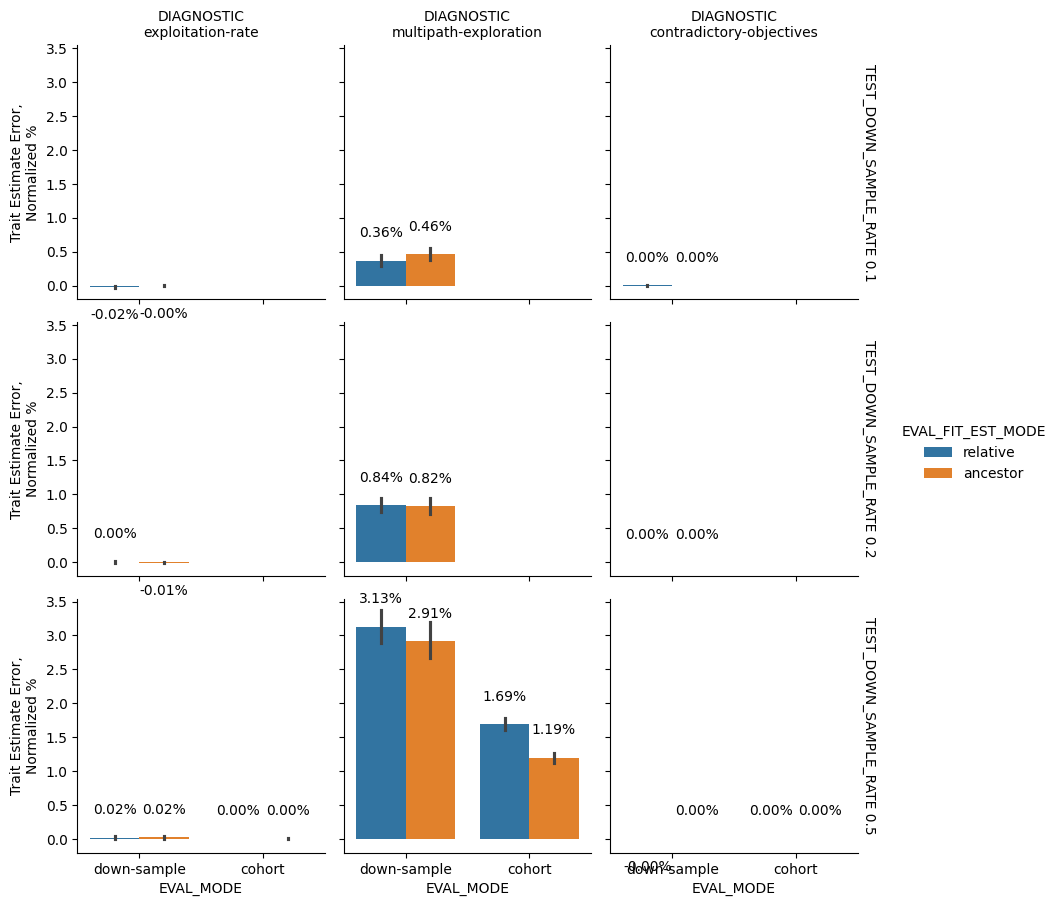

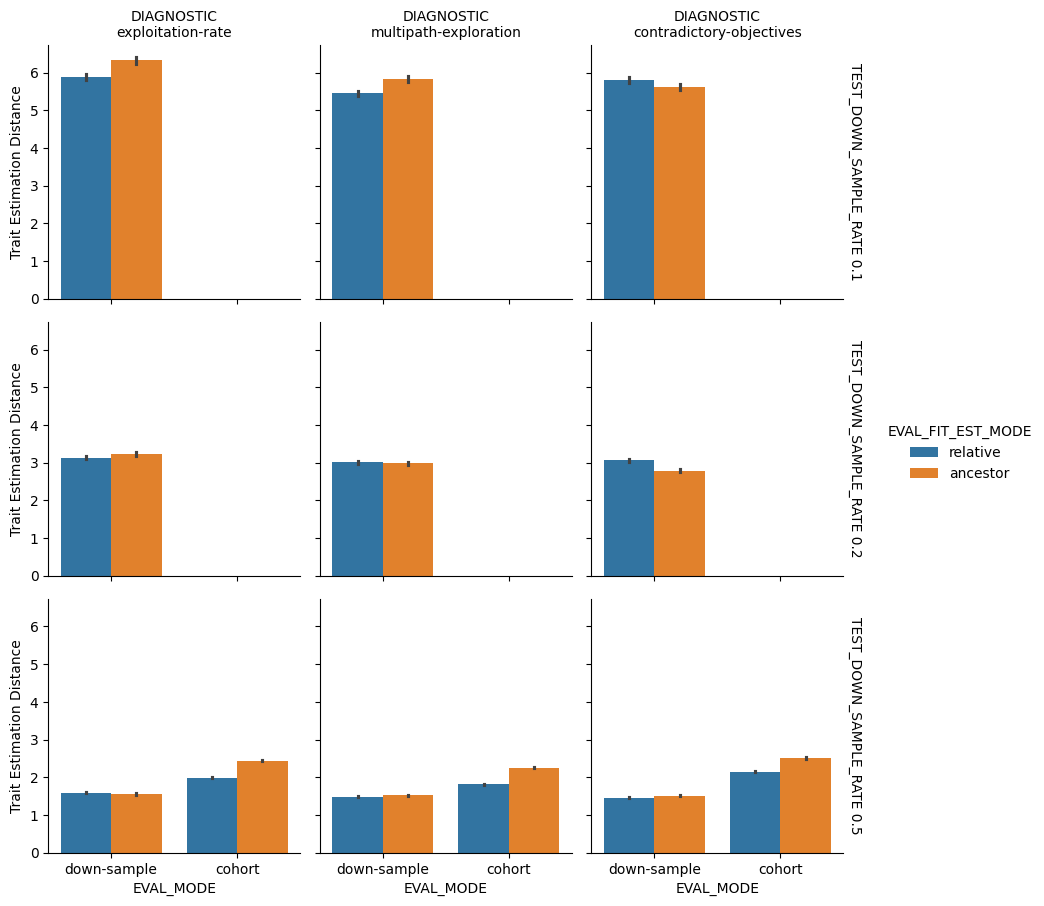

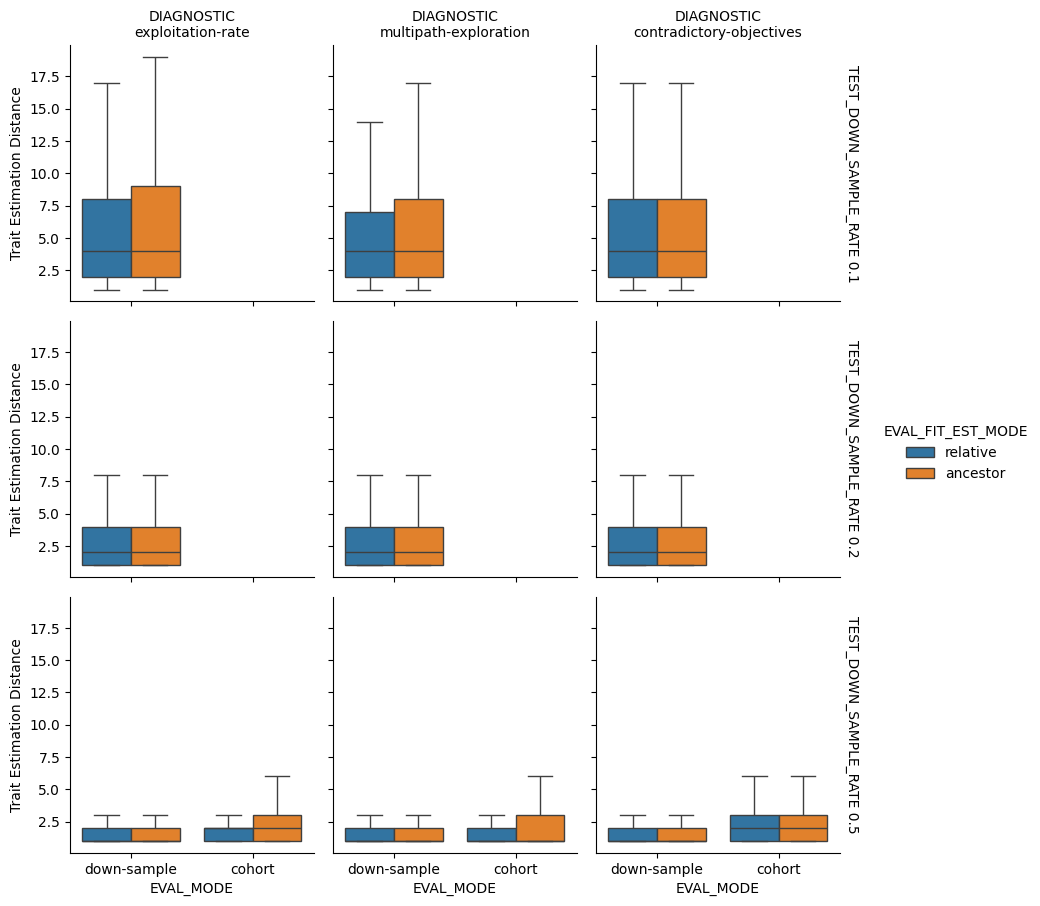

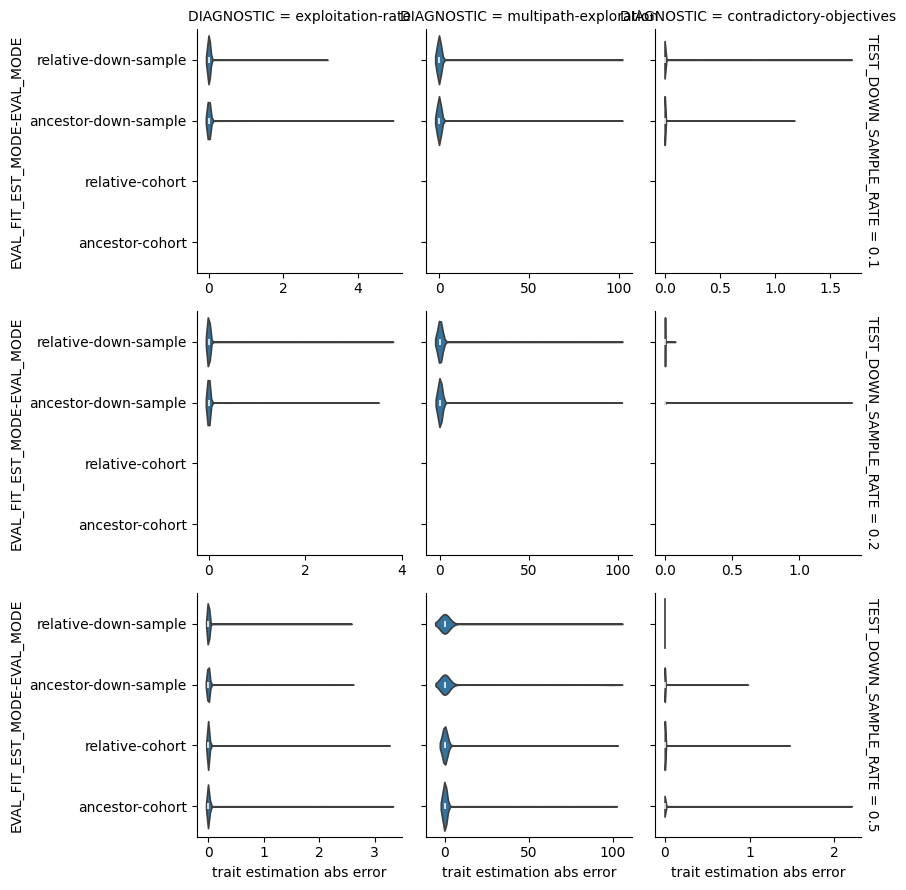

In [49]:
def facet_violinplot(data, x, y, col, row):
    g = sns.FacetGrid(
        data=data,
        col=col,
        row=row,
        margin_titles=True,
        sharex=False,
    )
    g.map(
        sns.violinplot,
        x,
        y,
    )

tp.tee(
    facet_violinplot,
    data=exploded_df[exploded_df["is successful estimation"]],
    x="trait estimation abs error",
    y="EVAL_FIT_EST_MODE-EVAL_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


teeplots/col=diagnostic+row=test-down-sample-rate+viz=facet-violinplot+x=abs-normalized-trait-estimation-error+y=eval-fit-est-mode+ext=.pdf


teeplots/col=diagnostic+row=test-down-sample-rate+viz=facet-violinplot+x=abs-normalized-trait-estimation-error+y=eval-fit-est-mode+ext=.png


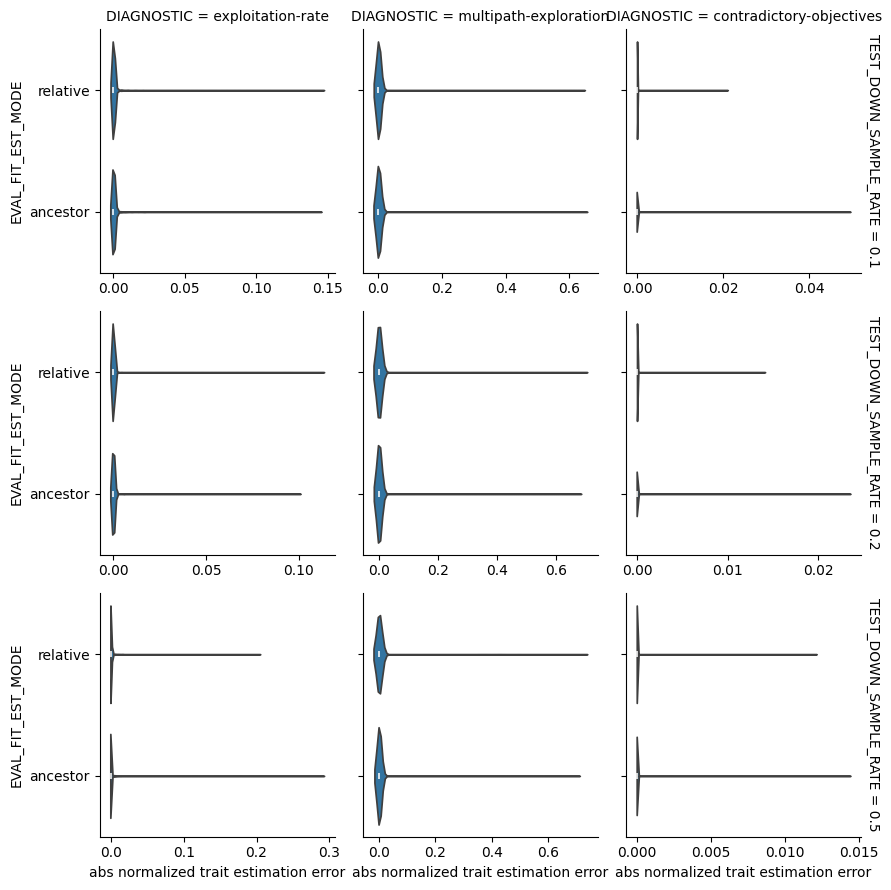

In [50]:
tp.tee(
    facet_violinplot,
    data=exploded_df[exploded_df["is successful estimation"]],
    x="abs normalized trait estimation error",
    y="EVAL_FIT_EST_MODE",
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
)


## Plot: relative vs. ancestor-based estimation efficacy for cohort vs downsample


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+viz=facet-barplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+viz=facet-barplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


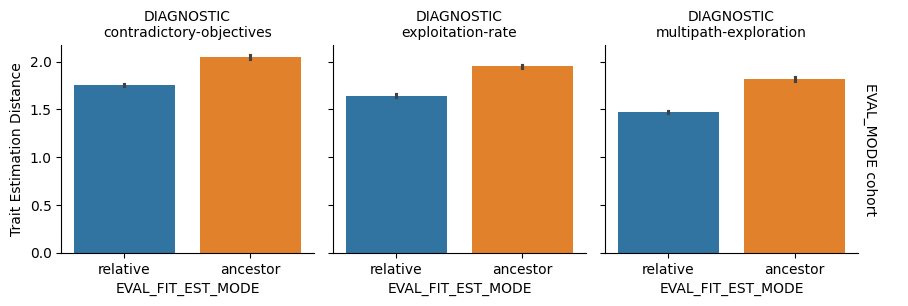

/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+viz=facet-barplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+viz=facet-barplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


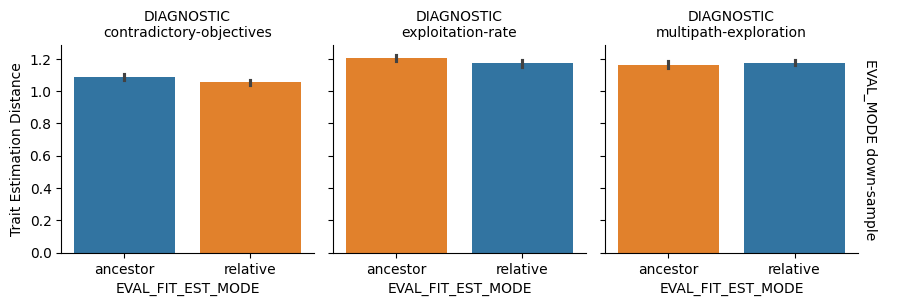

In [51]:
def facet_barplot(data, x, y, hue, row, col, col_order):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        col_order=col_order,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map_dataframe(
        sns.barplot,
        x=x,
        y=y,
        hue=hue,
        palette="tab10",
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimation Distance",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

for eval_mode in "cohort", "down-sample":
    tp.tee(
        facet_barplot,
        data=exploded_df[
            exploded_df["is successful estimation"]
            & (exploded_df["TEST_DOWN_SAMPLE_RATE"] == 0.5)
            & (exploded_df["EVAL_MODE"] == eval_mode)
        ],
        x="EVAL_FIT_EST_MODE",
        y="traits_estimation_dist",
        hue=None,
        col="DIAGNOSTIC",
        row="EVAL_MODE",
        col_order=sorted(exploded_df["DIAGNOSTIC"].unique()),
        teeplot_outattrs = {
            "EVAL_MODE" : eval_mode
        }
    )


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+showfliers=True+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+showfliers=True+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


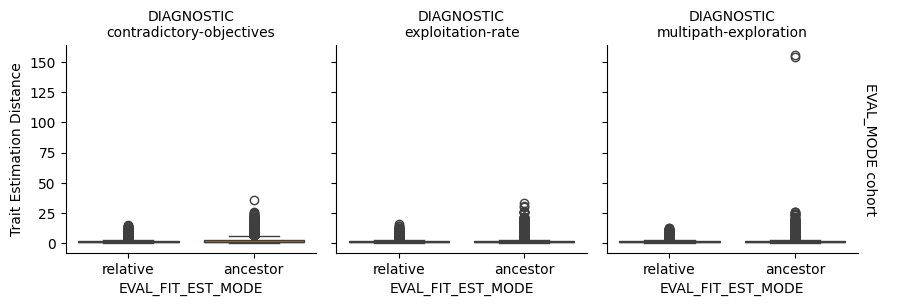

/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+showfliers=False+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=cohort+col=diagnostic+row=eval-mode+showfliers=False+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


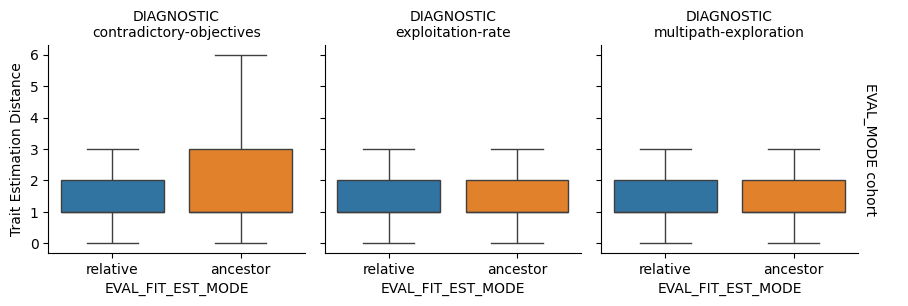

/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+showfliers=True+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+showfliers=True+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


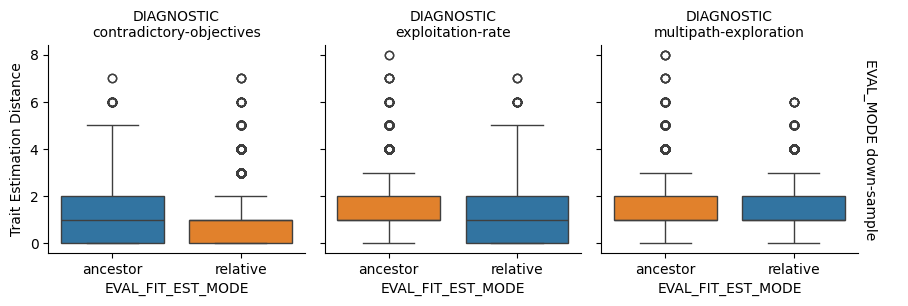

/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+showfliers=False+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.pdf


teeplots/EVAL_MODE=down-sample+col=diagnostic+row=eval-mode+showfliers=False+viz=facet-boxplot+x=eval-fit-est-mode+y=traits-estimation-dist+ext=.png


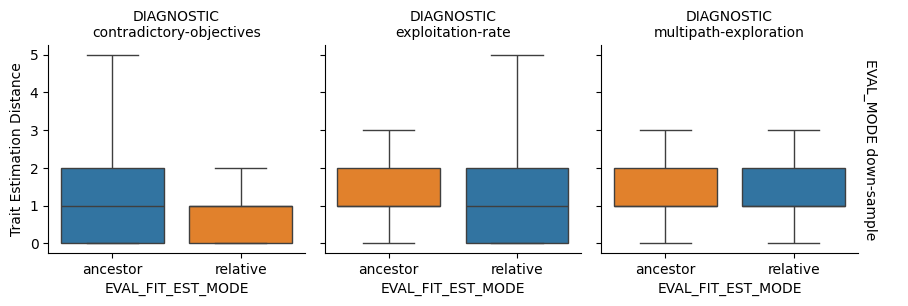

In [52]:
# note: it is ok to have zero-distance estimates
# search begins at the genome-taxon itself
# and if a copy of the genome has already been evaluated,
# then the cached result is returned
# see https://github.com/amlalejini/GPTP-2023-phylogeny-informed-evaluation/blob/9c01b2f1fc7756f90f8177b871ecf3a5ba612a14/include/phylogeny/phylogeny_utils.hpp#L227
# and https://github.com/amlalejini/GPTP-2023-phylogeny-informed-evaluation/blob/9c01b2f1fc7756f90f8177b871ecf3a5ba612a14/include/phylogeny/phylogeny_utils.hpp#L384
def facet_boxplot(data, x, y, hue, row, col, col_order, showfliers):
    g = sns.FacetGrid(
        data=data,
        row=row,
        col=col,
        col_order=col_order,
        margin_titles=True,
        sharey=True,
        sharex=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x=x,
        y=y,
        hue=hue,
        palette="tab10",
        showfliers=showfliers,
    ).add_legend(
        title=hue,
    ).set_axis_labels(
        y_var="Trait Estimation Distance",
    ).set_titles(
        col_template="{col_var}\n{col_name}",
        row_template="{row_var} {row_name}",
    )

for eval_mode, showfliers in it.product(
    ["cohort", "down-sample"],
    [True, False],
):
    tp.tee(
        facet_boxplot,
        data=exploded_df[
            exploded_df["is successful estimation"]
            & (exploded_df["TEST_DOWN_SAMPLE_RATE"] == 0.5)
            & (exploded_df["EVAL_MODE"] == eval_mode)
        ],
        x="EVAL_FIT_EST_MODE",
        y="traits_estimation_dist",
        hue=None,
        col="DIAGNOSTIC",
        row="EVAL_MODE",
        col_order=sorted(exploded_df["DIAGNOSTIC"].unique()),
        teeplot_outattrs = {
            "EVAL_MODE" : eval_mode,
            "showfliers" : str(showfliers),
        },
        showfliers=showfliers,
    )


# Statistics

## Correlation Estimation Distance vs Estimation Error


In [53]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]
records = []
for group, group_df in exploded_df.groupby(groupby_columns):
    group_attrs = dict(zip(groupby_columns, group))
    res = scipy_stats.spearmanr(
        group_df["traits_estimation_dist"],
        group_df["trait estimation abs error"],
    )
    records.append(
        {
            **group_attrs,
            **{
                "dist vs. error spearmanr correlation statistic" : res.statistic,
                "dist vs. error spearmanr correlation p" : res.pvalue,
                "significant?" : res.pvalue < 0.05,
            },
        }
    )

pd.DataFrame.from_records(records)


/home/runner/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,update,dist vs. error spearmanr correlation statistic,dist vs. error spearmanr correlation p,significant?
0,cohort,0.5,contradictory-objectives,ancestor,20000,-0.047096,4.209572e-33,True
1,cohort,0.5,contradictory-objectives,none,20000,NaN,NaN,False
2,cohort,0.5,contradictory-objectives,relative,20000,-0.050717,8.516699e-39,True
3,cohort,0.5,exploitation-rate,ancestor,20000,-0.570635,0.000000e+00,True
4,cohort,0.5,exploitation-rate,none,20000,NaN,NaN,False
5,cohort,0.5,exploitation-rate,relative,20000,-0.599790,0.000000e+00,True
6,cohort,0.5,multipath-exploration,ancestor,20000,-0.238904,0.000000e+00,True
7,cohort,0.5,multipath-exploration,none,20000,NaN,NaN,False
8,cohort,0.5,multipath-exploration,relative,20000,-0.218887,0.000000e+00,True
9,down-sample,0.1,contradictory-objectives,ancestor,20000,-0.000045,9.947683e-01,False


## Descriptive Statistics of Normalized Error Distributions


In [54]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]
records = []
for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    group_attrs = dict(zip(groupby_columns, group))
    data = group_df["normalized trait estimation error"]
    records.append(
        {
            **group_attrs,
            **{
                "mean normalized error" : data.mean(),
                "median normalized error" : data.median(),
                "1st percentile normalized error" : scipy_stats.scoreatpercentile(data, 1),
                "5th percentile normalized error" : scipy_stats.scoreatpercentile(data, 5),
                "95th percentile normalized error" : scipy_stats.scoreatpercentile(data, 95),
                "99th percentile normalized error" : scipy_stats.scoreatpercentile(data, 99),
            },
#             **dict(
#                 zip(
#                     ("95% CI lower bound", "95% CI upper bound"),
#                     scipy_stats.bootstrap(
#                         (data,),
#                         np.mean,
#                         batch=9,
#                         n_resamples=9,
#                     ).confidence_interval,
#                 )
#             ),
#             **dict(
#                 zip(
#                     ("99% CI lower bound", "99% CI upper bound"),
#                     scipy_stats.bootstrap(
#                         (data,),
#                         np.mean,
#                         batch=9,
#                         n_resamples=9,
#                         confidence_level=0.99,
#                     ).confidence_interval,
#                 )
#             )
        }
    )

pd.DataFrame.from_records(records)


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|▎         | 1/36 [00:00<00:14,  2.42it/s]

 67%|██████▋   | 24/36 [00:00<00:00, 60.84it/s]

100%|██████████| 36/36 [00:00<00:00, 66.10it/s]

,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,update,mean normalized error,median normalized error,1st percentile normalized error,5th percentile normalized error,95th percentile normalized error,99th percentile normalized error
0,cohort,0.5,contradictory-objectives,ancestor,20000,-0.001244,0.000000e+00,-5.551115e-17,-5.551115e-17,0.000000e+00,0.000000e+00
1,cohort,0.5,contradictory-objectives,none,20000,-0.005000,0.000000e+00,-4.840708e-03,-5.551115e-17,5.551115e-17,5.551115e-17
2,cohort,0.5,contradictory-objectives,relative,20000,-0.001185,0.000000e+00,-5.551115e-17,-5.551115e-17,0.000000e+00,0.000000e+00
3,cohort,0.5,exploitation-rate,ancestor,20000,-0.154643,0.000000e+00,-9.619741e-01,-8.624595e-01,0.000000e+00,1.110223e-16
4,cohort,0.5,exploitation-rate,none,20000,-0.500936,-5.009363e-01,-9.906367e-01,-9.513109e-01,-5.149813e-02,-1.123596e-02
5,cohort,0.5,exploitation-rate,relative,20000,-0.151631,0.000000e+00,-9.600000e-01,-8.608000e-01,1.110223e-16,1.110223e-16
6,cohort,0.5,multipath-exploration,ancestor,20000,-0.030553,0.000000e+00,-6.330508e-01,-4.669915e-01,0.000000e+00,4.177966e-01
7,cohort,0.5,multipath-exploration,none,20000,-0.137937,-5.551115e-17,-6.604938e-01,-6.031746e-01,0.000000e+00,5.551115e-17
8,cohort,0.5,multipath-exploration,relative,20000,-0.027905,0.000000e+00,-6.326616e-01,-4.710884e-01,5.551115e-17,4.736395e-01
9,down-sample,0.1,contradictory-objectives,ancestor,20000,-0.000156,0.000000e+00,0.000000e+00,0.000000e+00,5.551115e-17,5.551115e-17


## Descriptive Statistics of Normalized Absolute Error Distributions


In [55]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]
records = []
for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    group_attrs = dict(zip(groupby_columns, group))
    data = group_df["abs normalized trait estimation error"]
    records.append(
        {
            **group_attrs,
            **{
                "mean normalized absolute error" : data.mean(),
                "median normalized absolute error" : data.median(),
                "1st percentile normalized absolute error" : scipy_stats.scoreatpercentile(data, 1),
                "5th percentile normalized absolute error" : scipy_stats.scoreatpercentile(data, 5),
                "95th percentile normalized absolute error" : scipy_stats.scoreatpercentile(data, 95),
                "99th percentile normalized absolute error" : scipy_stats.scoreatpercentile(data, 99),
            },
        }
    )

pd.DataFrame.from_records(records)


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|▎         | 1/36 [00:00<00:13,  2.54it/s]

 72%|███████▏  | 26/36 [00:00<00:00, 68.34it/s]

100%|██████████| 36/36 [00:00<00:00, 69.28it/s]

,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,update,mean normalized absolute error,median normalized absolute error,1st percentile normalized absolute error,5th percentile normalized absolute error,95th percentile normalized absolute error,99th percentile normalized absolute error
0,cohort,0.5,contradictory-objectives,ancestor,20000,0.001246,0.000000e+00,0.000000,0.000000,5.551115e-17,5.551115e-17
1,cohort,0.5,contradictory-objectives,none,20000,0.005000,0.000000e+00,0.000000,0.000000,5.551115e-17,4.840708e-03
2,cohort,0.5,contradictory-objectives,relative,20000,0.001186,0.000000e+00,0.000000,0.000000,5.551115e-17,5.551115e-17
3,cohort,0.5,exploitation-rate,ancestor,20000,0.154935,1.387779e-17,0.000000,0.000000,8.624595e-01,9.619741e-01
4,cohort,0.5,exploitation-rate,none,20000,0.500936,5.009363e-01,0.011236,0.051498,9.513109e-01,9.906367e-01
5,cohort,0.5,exploitation-rate,relative,20000,0.151886,0.000000e+00,0.000000,0.000000,8.608000e-01,9.600000e-01
6,cohort,0.5,multipath-exploration,ancestor,20000,0.045173,0.000000e+00,0.000000,0.000000,4.889831e-01,6.347458e-01
7,cohort,0.5,multipath-exploration,none,20000,0.137937,5.551115e-17,0.000000,0.000000,6.031746e-01,6.604938e-01
8,cohort,0.5,multipath-exploration,relative,20000,0.049948,0.000000e+00,0.000000,0.000000,5.000000e-01,6.369048e-01
9,down-sample,0.1,contradictory-objectives,ancestor,20000,0.000175,0.000000e+00,0.000000,0.000000,5.551115e-17,5.551115e-17


## Did any estimations fail?


In [56]:
exploded_df["is failed estimation"].any()


False

## At the highest subsampling rate, what fractions of lookups were non-trivial (i.e., resolve to a non-self taxon)


### Cohort Lexicase


In [57]:
exploded_df[
    exploded_df["is successful estimation"]
   & (exploded_df["TEST_DOWN_SAMPLE_RATE"] == 0.5)
   &  (exploded_df["EVAL_MODE"] == "cohort")
]["traits_estimation_dist"].astype(bool).mean()


0.8115221838188615

### Down-sample Lexicase


In [58]:
exploded_df[
    exploded_df["is successful estimation"]
   & (exploded_df["TEST_DOWN_SAMPLE_RATE"] == 0.5)
   &  (exploded_df["EVAL_MODE"] == "down-sample")
]["traits_estimation_dist"].astype(bool).mean()


0.7495993458708095

## absolute normalized error by diagnostic ANOVA and Pairwise Comparisons


In [59]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "EVAL_FIT_EST_MODE",
    "update",
]
records = []
for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    group_attrs = dict(zip(groupby_columns, group))
    stat, p_value = scipy_stats.kruskal(
        *dict([*group_df.groupby("DIAGNOSTIC")["abs normalized trait estimation error"]]).values()
    )
    records.append(
        {
            **group_attrs,
            **{
                "normalized error by diagnostic kruskal-wallis p value" : p_value,
                "normalized error by diagnostic kruskal-wallis statistic" : stat,
                "significant?" : p_value < 0.05,
            },
        }
    )

pd.DataFrame.from_records(records)


  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:00<00:03,  2.81it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 22.02it/s]

100%|██████████| 12/12 [00:00<00:00, 24.18it/s]

,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,EVAL_FIT_EST_MODE,update,normalized error by diagnostic kruskal-wallis p value,normalized error by diagnostic kruskal-wallis statistic,significant?
0,cohort,0.5,ancestor,20000,0.0,37633.191777,True
1,cohort,0.5,none,20000,0.0,97199.847912,True
2,cohort,0.5,relative,20000,0.0,6321.148236,True
3,down-sample,0.1,ancestor,20000,0.0,5070.221455,True
4,down-sample,0.1,none,20000,0.0,43369.398468,True
5,down-sample,0.1,relative,20000,0.0,5265.033911,True
6,down-sample,0.2,ancestor,20000,0.0,4900.867981,True
7,down-sample,0.2,none,20000,0.0,40681.258930,True
8,down-sample,0.2,relative,20000,0.0,2884.859238,True
9,down-sample,0.5,ancestor,20000,0.0,13407.741964,True


In [60]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "EVAL_FIT_EST_MODE",
    "update",
]

records = []

for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    group_attrs = dict(zip(groupby_columns, group))
    diagnostic_groups = dict([*group_df.groupby("DIAGNOSTIC")["abs normalized trait estimation error"]])

    pairwise_comparisons = [*it.combinations(diagnostic_groups.keys(), 2)]
    p_values = []
    for first_diagnostic, second_diagnostic in pairwise_comparisons:
        stat, p_value = scipy_stats.mannwhitneyu(
            diagnostic_groups[first_diagnostic],
            diagnostic_groups[second_diagnostic],
            alternative='two-sided',
        )
        p_values.append(p_value)

    # Apply Bonferroni correction
    corrected_p_values = statsmodels_stats_multitest.multipletests(
        p_values, method='bonferroni'
    )[1]

    for (
        (first_diagnostic, second_diagnostic),
        p_value,
        corrected_p_value,
    ) in zip(pairwise_comparisons, p_values, corrected_p_values):
        if np.median(diagnostic_groups[first_diagnostic]) < np.median(diagnostic_groups[second_diagnostic]):
            lower_error_diagnostic = first_diagnostic
            higher_error_diagnostic = second_diagnostic
        else:
            lower_error_diagnostic = second_diagnostic
            higher_error_diagnostic = first_diagnostic

        records.append(
            {
                **group_attrs,
                "lower error diagnostic": lower_error_diagnostic,
                "higher error diagnostic": higher_error_diagnostic,
                "p value": p_value,
                "corrected p value": corrected_p_value,
                "significant?" : corrected_p_value < 0.05,
            }
        )

pd.DataFrame.from_records(records)


  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:00<00:05,  1.90it/s]

 17%|█▋        | 2/12 [00:00<00:03,  2.97it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.56it/s]

 42%|████▏     | 5/12 [00:01<00:01,  6.36it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  8.76it/s]

 75%|███████▌  | 9/12 [00:01<00:00, 10.63it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 11.91it/s]

100%|██████████| 12/12 [00:01<00:00,  7.92it/s]

,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,EVAL_FIT_EST_MODE,update,lower error diagnostic,higher error diagnostic,p value,corrected p value,significant?
0,cohort,0.5,ancestor,20000,contradictory-objectives,exploitation-rate,0.000000e+00,0.000000e+00,True
1,cohort,0.5,ancestor,20000,multipath-exploration,contradictory-objectives,0.000000e+00,0.000000e+00,True
2,cohort,0.5,ancestor,20000,multipath-exploration,exploitation-rate,0.000000e+00,0.000000e+00,True
3,cohort,0.5,none,20000,contradictory-objectives,exploitation-rate,0.000000e+00,0.000000e+00,True
4,cohort,0.5,none,20000,contradictory-objectives,multipath-exploration,0.000000e+00,0.000000e+00,True
5,cohort,0.5,none,20000,multipath-exploration,exploitation-rate,0.000000e+00,0.000000e+00,True
6,cohort,0.5,relative,20000,exploitation-rate,contradictory-objectives,0.000000e+00,0.000000e+00,True
7,cohort,0.5,relative,20000,multipath-exploration,contradictory-objectives,1.776315e-196,5.328946e-196,True
8,cohort,0.5,relative,20000,multipath-exploration,exploitation-rate,0.000000e+00,0.000000e+00,True
9,down-sample,0.1,ancestor,20000,exploitation-rate,contradictory-objectives,0.000000e+00,0.000000e+00,True


## absolute normalized error by down sample rate, ANOVA and pairwise comparisons


In [61]:
groupby_columns = [
    "EVAL_MODE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]
records = []
for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    if len(group_df["TEST_DOWN_SAMPLE_RATE"].unique()) == 1:
        continue

    group_attrs = dict(zip(groupby_columns, group))
    stat, p_value = scipy_stats.kruskal(
        *dict([*group_df.groupby("TEST_DOWN_SAMPLE_RATE")["abs normalized trait estimation error"]]).values()
    )
    records.append(
        {
            **group_attrs,
            **{
                "normalized error by down-sample rate kruskal-wallis p value" : p_value,
                "normalized error by down-sample rate kruskal-wallis statistic" : stat,
            },
        }
    )

pd.DataFrame.from_records(records)


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:06,  2.78it/s]

100%|██████████| 18/18 [00:00<00:00, 41.56it/s]

,EVAL_MODE,DIAGNOSTIC,EVAL_FIT_EST_MODE,update,normalized error by down-sample rate kruskal-wallis p value,normalized error by down-sample rate kruskal-wallis statistic
0,down-sample,contradictory-objectives,ancestor,20000,1.851317e-75,344.155969
1,down-sample,contradictory-objectives,none,20000,1.315982e-23,105.369748
2,down-sample,contradictory-objectives,relative,20000,0.000000e+00,4921.773246
3,down-sample,exploitation-rate,ancestor,20000,0.000000e+00,5904.186390
4,down-sample,exploitation-rate,none,20000,9.914639e-01,0.017145
5,down-sample,exploitation-rate,relative,20000,0.000000e+00,4767.797697
6,down-sample,multipath-exploration,ancestor,20000,0.000000e+00,2786.230397
7,down-sample,multipath-exploration,none,20000,0.000000e+00,25073.226904
8,down-sample,multipath-exploration,relative,20000,5.985412e-200,917.455387


In [62]:
groupby_columns = [
    "EVAL_MODE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]

records = []

for group, group_df in tqdm(exploded_df.groupby(groupby_columns)):
    if len(group_df["TEST_DOWN_SAMPLE_RATE"].unique()) == 1:

        continue

    group_attrs = dict(zip(groupby_columns, group))
    downsample_groups = dict([*group_df.groupby("TEST_DOWN_SAMPLE_RATE")["abs normalized trait estimation error"]])

    pairwise_comparisons = [*it.combinations(downsample_groups.keys(), 2)]
    p_values = []
    for first_downsample, second_downsample in pairwise_comparisons:
        stat, p_value = scipy_stats.mannwhitneyu(
            downsample_groups[first_downsample],
            downsample_groups[second_downsample],
            alternative='two-sided',
        )
        p_values.append(p_value)

    # Apply Bonferroni correction
    corrected_p_values = statsmodels_stats_multitest.multipletests(
        p_values, method='bonferroni',
    )[1]

    for (
        (first_downsample, second_downsample),
        p_value,
        corrected_p_value,
    ) in zip(pairwise_comparisons, p_values, corrected_p_values):
        if np.median(downsample_groups[first_downsample]) < np.median(downsample_groups[second_downsample]):
            lower_error_downsample = first_downsample
            higher_error_downsample = second_downsample
        else:
            lower_error_downsample = second_downsample
            higher_error_downsample = first_downsample

        records.append(
            {
                **group_attrs,
                "lower error downsample": lower_error_downsample,
                "higher error downsample": higher_error_downsample,
                "p value": p_value,
                "corrected p value": corrected_p_value,
                "significant?" : corrected_p_value < 0.05,
            }
        )

pd.DataFrame.from_records(records)


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:06,  2.75it/s]

 61%|██████    | 11/18 [00:00<00:00, 28.29it/s]

 89%|████████▉ | 16/18 [00:00<00:00, 21.27it/s]

100%|██████████| 18/18 [00:00<00:00, 19.42it/s]

,EVAL_MODE,DIAGNOSTIC,EVAL_FIT_EST_MODE,update,lower error downsample,higher error downsample,p value,corrected p value,significant?
0,down-sample,contradictory-objectives,ancestor,20000,0.2,0.1,8.214316e-30,2.464295e-29,True
1,down-sample,contradictory-objectives,ancestor,20000,0.5,0.1,1.263949e-76,3.791847e-76,True
2,down-sample,contradictory-objectives,ancestor,20000,0.5,0.2,2.835998e-13,8.507995e-13,True
3,down-sample,contradictory-objectives,none,20000,0.2,0.1,3.412959e-07,1.023888e-06,True
4,down-sample,contradictory-objectives,none,20000,0.5,0.1,1.172800e-07,3.518399e-07,True
5,down-sample,contradictory-objectives,none,20000,0.5,0.2,1.270272e-24,3.810817e-24,True
6,down-sample,contradictory-objectives,relative,20000,0.2,0.1,0.000000e+00,0.000000e+00,True
7,down-sample,contradictory-objectives,relative,20000,0.5,0.1,0.000000e+00,0.000000e+00,True
8,down-sample,contradictory-objectives,relative,20000,0.5,0.2,2.389395e-201,7.168185e-201,True
9,down-sample,exploitation-rate,ancestor,20000,0.2,0.1,9.184339e-63,2.755302e-62,True


## Stats: relative vs. ancestor-based estimation efficacy for cohort vs downsample


In [63]:
data=exploded_df[
    exploded_df["is successful estimation"]
    & (exploded_df["TEST_DOWN_SAMPLE_RATE"] == 0.5)
]

for group, group_df in data.groupby(["EVAL_MODE", "DIAGNOSTIC"]):
    print(group)
    res = scipy_stats.mannwhitneyu(
        group_df[group_df["EVAL_FIT_EST_MODE"] == "ancestor"]["traits_estimation_dist"],
        group_df[group_df["EVAL_FIT_EST_MODE"] == "relative"]["traits_estimation_dist"],
    )
    print(res)
    print("p value conservatively corrected for 6 comparisons", res[1] * 6)

    mean_ancestor = group_df[group_df["EVAL_FIT_EST_MODE"] == "ancestor"]["traits_estimation_dist"].mean()
    mean_relative = group_df[group_df["EVAL_FIT_EST_MODE"] == "relative"]["traits_estimation_dist"].mean()
    print(f"{mean_ancestor=} {mean_relative=}")
    if mean_ancestor > mean_relative:
        print("mean_ancestor > mean_relative")
        print("effect size", (mean_ancestor - mean_relative) / mean_relative)
    elif mean_relative > mean_ancestor:
        print("mean_relative > mean_ancestor")
        print("effect size", (mean_relative - mean_ancestor) / mean_ancestor)
    else:
        assert False
    print("---\n")


('cohort', 'contradictory-objectives')
MannwhitneyuResult(statistic=1276252337.0, pvalue=3.7206180707822e-11)
p value conservatively corrected for 6 comparisons 2.2323708424693202e-10
mean_ancestor=2.045695766659915 mean_relative=1.7556809184481394
mean_ancestor > mean_relative
effect size 0.1651865354144886
---

('cohort', 'exploitation-rate')
MannwhitneyuResult(statistic=1117502586.0, pvalue=0.00023161688988127547)
p value conservatively corrected for 6 comparisons 0.0013897013392876528


mean_ancestor=1.948423761526914 mean_relative=1.6431501057082452
mean_ancestor > mean_relative
effect size 0.18578561676024544
---

('cohort', 'multipath-exploration')
MannwhitneyuResult(statistic=1043169007.5, pvalue=1.4926101471916312e-23)
p value conservatively corrected for 6 comparisons 8.955660883149787e-23
mean_ancestor=1.815751896474788 mean_relative=1.469510022271715
mean_ancestor > mean_relative
effect size 0.23561722543941407
---

('down-sample', 'contradictory-objectives')
MannwhitneyuResult(statistic=60951497.0, pvalue=0.14845954910462886)
p value conservatively corrected for 6 comparisons 0.8907572946277731
mean_ancestor=1.0861538461538462 mean_relative=1.055948275862069
mean_ancestor > mean_relative
effect size 0.028605160860855187
---

('down-sample', 'exploitation-rate')
MannwhitneyuResult(statistic=50826474.0, pvalue=0.014886657281090248)
p value conservatively corrected for 6 comparisons 0.08931994368654149
mean_ancestor=1.202870813397129 mean_relative=1.172251308900